# Universidad del Valle de Guatemala
## Facultad de Ingeniería
### Departamento de Computación

---

# Laboratorio 6: Análisis de sentimientos

**Integrantes:**
- Diego Alexander Hernández Silvestre, 21270
- Linda Inés Jiménez Vides, 21169

**Curso:** Data Science  
**Sección:** 10  

---

Guatemala, 5 de septiembre de 2024


### 🚨 Se puede descargar manualmente el dataset mediante el enlace de abajo o ejecutando el código proporcionado. (Es necesario una cuenta y una key de kaggle). Es importante descomprimir el archivo en la carpeta data.

In [56]:
import os
import opendatasets as od
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from nltk import ngrams, trigrams, bigrams
from tabulate import tabulate
from collections import Counter
import seaborn as sns
from matplotlib_venn import venn2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.sentiment import SentimentIntensityAnalyzer

# 🌋 Ejercicio 1

In [12]:
def printText(df, stop = 10):
    for i, t in enumerate(df):
        print(i, t)
        if i >= stop:
            break

### 📩 Inciso 1. Descargar el archivo train.csv

In [32]:
if not os.path.isdir('nlp-getting-started'):
    od.download("https://www.kaggle.com/c/nlp-getting-started/data")

### 📩 Inciso 2. Carga de los datos

In [33]:
dataTrain = pd.read_csv('nlp-getting-started/train.csv')
dataTest = pd.read_csv('nlp-getting-started/test.csv')
dataSampleSubmission = pd.read_csv('nlp-getting-started/sample_submission.csv')

### 🧹 Inciso 3. Preprocesamiento y limpieza de datos

In [34]:
dataTrain.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [35]:
dataTrain.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [36]:
for i, element in enumerate(dataTrain.columns):
    print(str(i+1)+")📚["+element+"].Count:", dataTrain[element].count())

1)📚[id].Count: 7613
2)📚[keyword].Count: 7552
3)📚[location].Count: 5080
4)📚[text].Count: 7613
5)📚[target].Count: 7613


In [37]:
text = dataTrain['text']

Comenzando con este laboratorio lo primero que se hizo fue una limpieza y preprocesamiento de los datos, los cuales nos ayudarán para una mejor predicción de los mismos a la hora que nuestros modelos tengan que leer y clasificar los tweets.

Un poco de lo que realizamos para su limpieza fue:
- Eliminación de URLs presentes en los tweets para evitar que estos influyan en procesos posteriores
- Conversión a minúsculas de los textos para normalizar los datos.
- Eliminación de caracteres especiales para limpiar el texto y enfocarse en palabras
- Eliminación de patrones extraños como múltiples signos de exclamación, caracteres como **&** ya que se presentaban como **&amp** y saltos de líneas reemplazados por espacios.
- Reducción de repetición de letras consecutivamente así como **gooooaaaal** se normalizo a la palabra original **goal**.
- Eliminación de puntos y coma.
- Eliminación de espacios en blanco extras dejando solamente uno.
- Eliminación de stopwords, es decir palabras comunes que no aportan mucho significado pro sí solas, enfocandonos en palabras más significativas del texto.

Todo lo descrito anteriormente se puede ver el procedimiento a continuación:

#### 🖼️ Removiendo urls

In [38]:
textWithoutUrl = text.str.replace(r'http\S+|www\S+', '', regex=True)
printText(textWithoutUrl, 100)

0 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1 Forest fire near La Ronge Sask. Canada
2 All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3 13,000 people receive #wildfires evacuation orders in California 
4 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
5 #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
6 #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
7 I'm on top of the hill and I can see a fire in the woods...
8 There's an emergency evacuation happening now in the building across the street
9 I'm afraid that the tornado is coming to our area...
10 Three people died from the heat wave so far
11 Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
12

#### 🔡 Convertir a minúsculas. 

In [39]:
textLowerCase = textWithoutUrl.str.lower()
textLowerCase.head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

#### 🤔 Removiendo caracteres especiales (@/#/')

In [40]:
textWithouthSpecialCharacthers = textLowerCase.str.replace('@', '')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('#', '')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace("'", "")
textWithouthSpecialCharacthers.head()

0    our deeds are the reason of this earthquake ma...
1               forest fire near la ronge sask. canada
2    all residents asked to shelter in place are be...
3    13,000 people receive wildfires evacuation ord...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

#### 👾 Removiendo patrones extraños

In [41]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'\?+', '?', regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'\!+', '!', regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('&amp;', 'and')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('\n', ' ')
printText(textWithouthSpecialCharacthers, stop=20)

0 our deeds are the reason of this earthquake may allah forgive us all
1 forest fire near la ronge sask. canada
2 all residents asked to shelter in place are being notified by officers. no other evacuation or shelter in place orders are expected
3 13,000 people receive wildfires evacuation orders in california 
4 just got sent this photo from ruby alaska as smoke from wildfires pours into a school 
5 rockyfire update => california hwy. 20 closed in both directions due to lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding of streets in manitou, colorado springs areas
7 im on top of the hill and i can see a fire in the woods...
8 theres an emergency evacuation happening now in the building across the street
9 im afraid that the tornado is coming to our area...
10 three people died from the heat wave so far
11 haha south tampa is getting flooded hah- wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding
12 raining floodi

#### 📚 Reduciendo la cantidad de letras repetidas

In [42]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'(\.{3,})', 'THREEPOINTSIDENFIFIER', regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'(.)\1{'+str(2)+',}', r'\1' * 2, regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('THREEPOINTSIDENFIFIER', '...')
textWithouthSpecialCharacthers

0       our deeds are the reason of this earthquake ma...
1                  forest fire near la ronge sask. canada
2       all residents asked to shelter in place are be...
3       13,00 people receive wildfires evacuation orde...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria_ahrary thetawniest the out of control wil...
7610          m1.94 [01:04 utc]?5km s of volcano hawaii. 
7611    police investigating after an e-bike collided ...
7612    the latest: more homes razed by northern calif...
Name: text, Length: 7613, dtype: object

#### 🛹 Quintando puntos y comas.

In [43]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('.',' ')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(',',' ')
printText(textWithouthSpecialCharacthers, 100)

0 our deeds are the reason of this earthquake may allah forgive us all
1 forest fire near la ronge sask  canada
2 all residents asked to shelter in place are being notified by officers  no other evacuation or shelter in place orders are expected
3 13 00 people receive wildfires evacuation orders in california 
4 just got sent this photo from ruby alaska as smoke from wildfires pours into a school 
5 rockyfire update => california hwy  20 closed in both directions due to lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding of streets in manitou  colorado springs areas
7 im on top of the hill and i can see a fire in the woods   
8 theres an emergency evacuation happening now in the building across the street
9 im afraid that the tornado is coming to our area   
10 three people died from the heat wave so far
11 haha south tampa is getting flooded hah- wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding
12 raining floodin

#### 🧹 Removiendo varios espacios en blanco y dejando solo uno

In [44]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'\s{2,}', ' ', regex=True)
printText(textWithouthSpecialCharacthers, 100)

0 our deeds are the reason of this earthquake may allah forgive us all
1 forest fire near la ronge sask canada
2 all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
3 13 00 people receive wildfires evacuation orders in california 
4 just got sent this photo from ruby alaska as smoke from wildfires pours into a school 
5 rockyfire update => california hwy 20 closed in both directions due to lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas
7 im on top of the hill and i can see a fire in the woods 
8 theres an emergency evacuation happening now in the building across the street
9 im afraid that the tornado is coming to our area 
10 three people died from the heat wave so far
11 haha south tampa is getting flooded hah- wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding
12 raining flooding florid

#### 🧹 Removiendo stopwords    

In [45]:
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))

def removeStopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopWords]  
    return ' '.join(filtered_words)

textWithoutStopwords = textWithouthSpecialCharacthers.apply(removeStopwords)
printText(textWithoutStopwords, 100)

0 deeds reason earthquake may allah forgive us
1 forest fire near la ronge sask canada
2 residents asked shelter place notified officers evacuation shelter place orders expected
3 13 00 people receive wildfires evacuation orders california
4 got sent photo ruby alaska smoke wildfires pours school
5 rockyfire update => california hwy 20 closed directions due lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding streets manitou colorado springs areas
7 im top hill see fire woods
8 theres emergency evacuation happening building across street
9 im afraid tornado coming area
10 three people died heat wave far
11 haha south tampa getting flooded hah- wait second live south tampa gonna gonna fvck flooding
12 raining flooding florida tampabay tampa 18 19 days ive lost count
13 flood bago myanmar arrived bago
14 damage school bus 80 multi car crash breaking
15 whats man?
16 love fruits
17 summer lovely
18 car fast
19 gooaal!
20 ridiculous
21 london cool ;)
22 lov

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lijv1.LINDA_HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
import re

def remove_numbers_except_911(text):
    # Reemplazar números por espacios, excepto 911
    # Esta expresión regular busca todos los números excepto 911
    text = re.sub(r'\b(?!911\b)\d+\b', ' ', text)
    
    # Opcional: elimina múltiples espacios consecutivos generados
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

textWithoutNumbers = textWithoutStopwords.apply(remove_numbers_except_911)
printText(textWithoutNumbers, 100)

0 deeds reason earthquake may allah forgive us
1 forest fire near la ronge sask canada
2 residents asked shelter place notified officers evacuation shelter place orders expected
3 people receive wildfires evacuation orders california
4 got sent photo ruby alaska smoke wildfires pours school
5 rockyfire update => california hwy closed directions due lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding streets manitou colorado springs areas
7 im top hill see fire woods
8 theres emergency evacuation happening building across street
9 im afraid tornado coming area
10 three people died heat wave far
11 haha south tampa getting flooded hah- wait second live south tampa gonna gonna fvck flooding
12 raining flooding florida tampabay tampa days ive lost count
13 flood bago myanmar arrived bago
14 damage school bus multi car crash breaking
15 whats man?
16 love fruits
17 summer lovely
18 car fast
19 gooaal!
20 ridiculous
21 london cool ;)
22 love skiing
23 wonder

In [47]:
textWithoutStopwords = textWithoutNumbers.str.replace(r'[^\w\s]','',regex=True)

### Inciso 4. 🖼️ Frecuencia de palabras

In [48]:
nltk.download('punkt_tab')
tokenizedText = textWithoutStopwords.apply(word_tokenize)
allWords = [word for words in tokenizedText for word in words]
wordCounts = Counter(allWords)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lijv1.LINDA_HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


       Word  Frequency
127    like        346
56       im        302
8      fire        252
227     get        229
158     new        224
746     via        220
23   people        196
715    news        194
596     one        192
347    dont        192


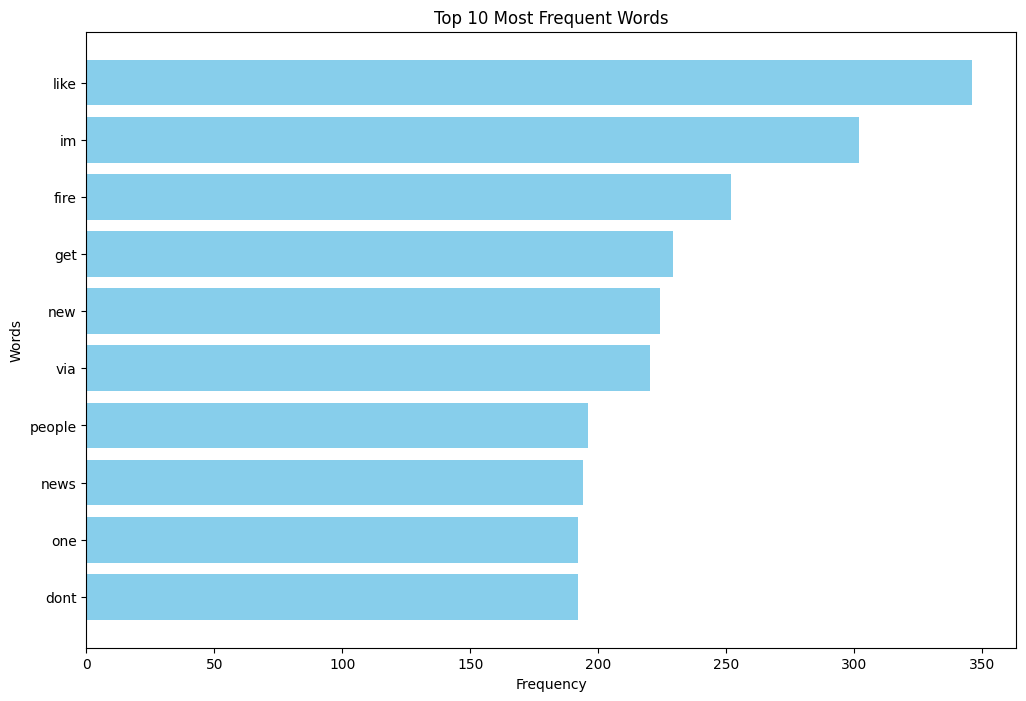

In [49]:
wordFreqDf = pd.DataFrame(wordCounts.items(), columns=['Word', 'Frequency'])
wordFreqDf = wordFreqDf.sort_values(by='Frequency', ascending=False)
print(wordFreqDf.head(10))
plt.figure(figsize=(12, 8))
plt.barh(wordFreqDf['Word'].head(10), wordFreqDf['Frequency'].head(10), color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 10 Most Frequent Words')
plt.gca().invert_yaxis() 
plt.show()

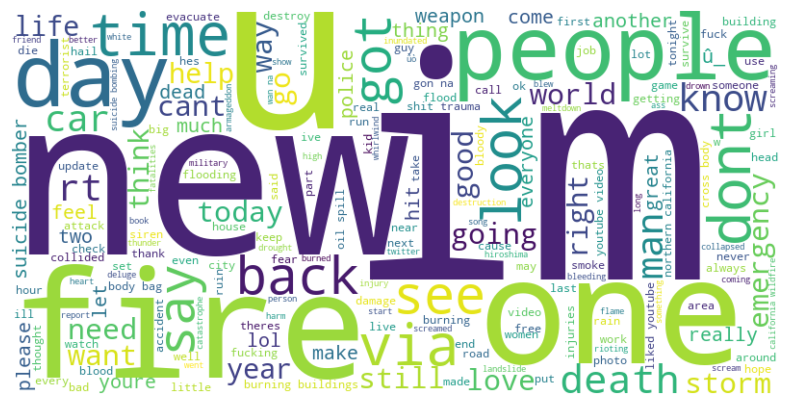

In [50]:
completeText = ' '.join(allWords)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(completeText)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

🔄 Generando 2-gramas...
📈 Mostrando los 10 2-gramas más frecuentes:
Label                   Disasters  No Disasters
2-gram                                         
(burning, buildings)         35.0          23.0
(california, wildfire)       34.0           NaN
(cross, body)                 1.0          38.0
(gon, na)                    11.0          32.0
(liked, youtube)              7.0          35.0
(northern, california)       41.0           NaN
(oil, spill)                 38.0           1.0
(suicide, bomber)            59.0           NaN
(wan, na)                     5.0          30.0
(youtube, video)              7.0          36.0


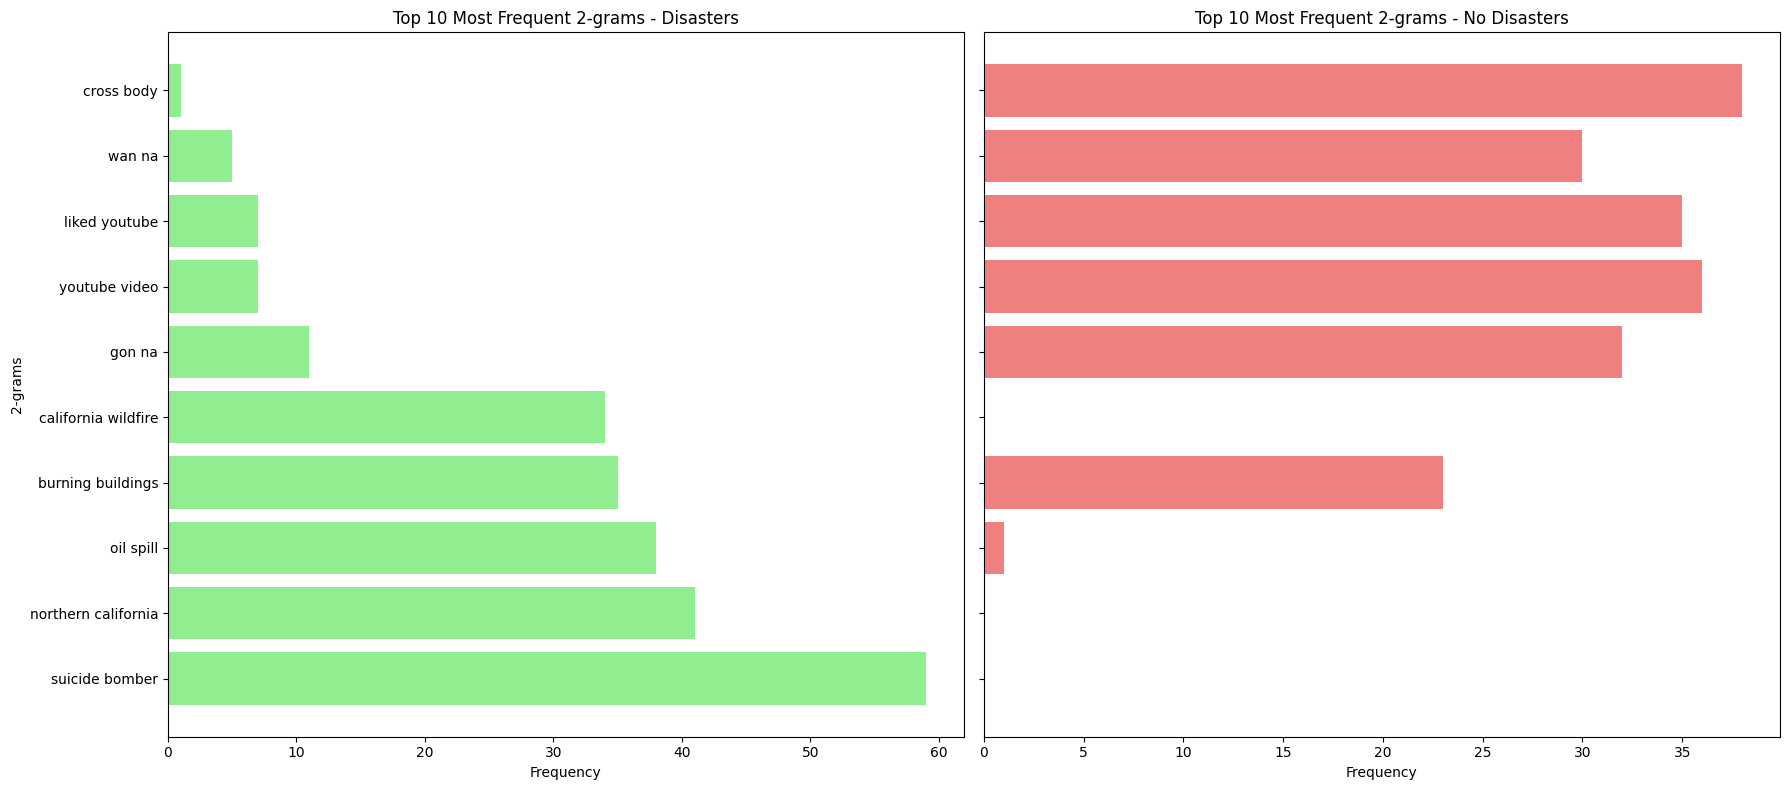

✅ Gráficos de 2-gramas generados.
🔄 Generando 3-gramas...
📈 Mostrando los 10 3-gramas más frecuentes:
Label                             Disasters  No Disasters
3-gram                                                   
(16yr, old, pkk)                       27.0           NaN
(bomber, detonated, bomb)              28.0           NaN
(homes, razed, northern)               28.0           NaN
(latest, homes, razed)                 28.0           NaN
(liked, youtube, video)                 7.0          35.0
(northern, california, wildfire)       29.0           NaN
(old, pkk, suicide)                    27.0           NaN
(pkk, suicide, bomber)                 28.0           NaN
(razed, northern, california)          27.0           NaN
(suicide, bomber, detonated)           30.0           NaN


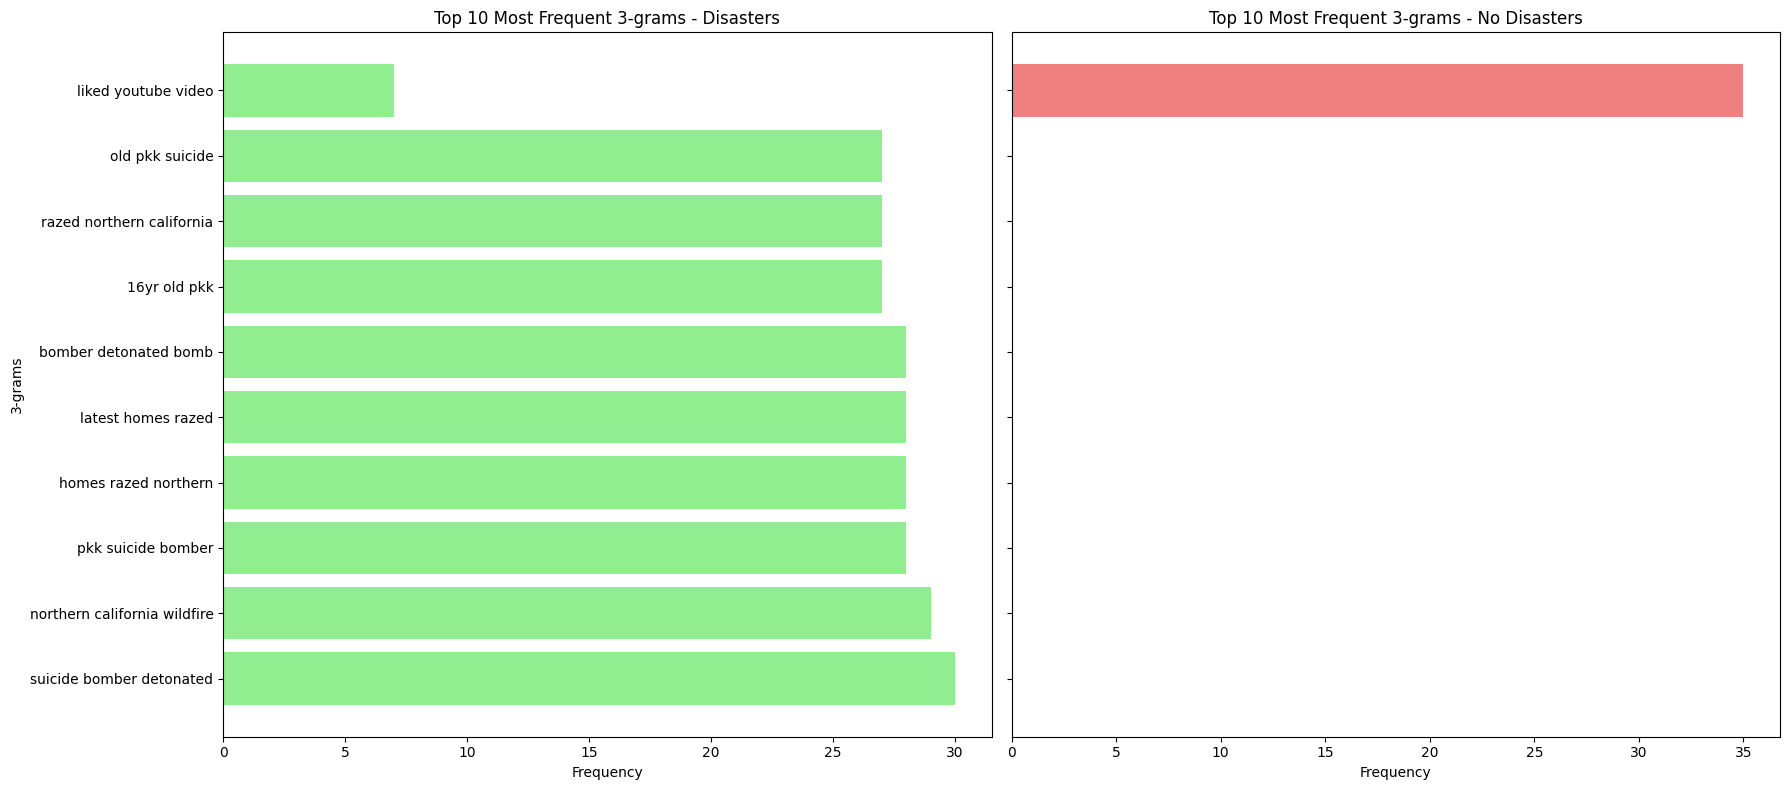

✅ Gráficos de 3-gramas generados.


In [51]:
def ngramAnalysis(tokenizedTextColumn, targetColumn, n=2):
    print(f"🔄 Generando {n}-gramas...")

    disasterTweets = tokenizedTextColumn[targetColumn == 1]
    nonDisasterTweets = tokenizedTextColumn[targetColumn == 0]
    
    def analyzeNgrams(texts, label):
        ngramsList = [ngram for tokens in texts for ngram in ngrams(tokens, n)]
        ngramCounts = Counter(ngramsList)
        ngramFreqDf = pd.DataFrame(ngramCounts.items(), columns=[f'{n}-gram', 'Frequency']).sort_values(by='Frequency', ascending=False)
        ngramFreqDf['Label'] = label
        return ngramFreqDf
    
    disasterNgramsDf = analyzeNgrams(disasterTweets, 'Disasters')
    nonDisasterNgramsDf = analyzeNgrams(nonDisasterTweets, 'No Disasters')
    
    topNgrams = pd.concat([disasterNgramsDf, nonDisasterNgramsDf]).groupby([f'{n}-gram'])['Frequency'].sum().sort_values(ascending=False).head(10).index
    topNgramsDf = pd.concat([disasterNgramsDf, nonDisasterNgramsDf])
    topNgramsDf = topNgramsDf[topNgramsDf[f'{n}-gram'].isin(topNgrams)]

    print(f"📈 Mostrando los 10 {n}-gramas más frecuentes:")
    print(topNgramsDf.groupby([f'{n}-gram', 'Label'])['Frequency'].sum().unstack())


    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
    

    disasterSubset = topNgramsDf[topNgramsDf['Label'] == 'Disasters']
    axs[0].barh([' '.join(ngram) for ngram in disasterSubset[f'{n}-gram']], disasterSubset['Frequency'], color='lightgreen')
    axs[0].set_xlabel('Frequency')
    axs[0].set_ylabel(f'{n}-grams')
    axs[0].set_title(f'Top 10 Most Frequent {n}-grams - Disasters')
    axs[0].invert_yaxis()
    
    nonDisasterSubset = topNgramsDf[topNgramsDf['Label'] == 'No Disasters']
    axs[1].barh([' '.join(ngram) for ngram in nonDisasterSubset[f'{n}-gram']], nonDisasterSubset['Frequency'], color='lightcoral')
    axs[1].set_xlabel('Frequency')
    axs[1].set_title(f'Top 10 Most Frequent {n}-grams - No Disasters')
    axs[1].invert_yaxis()

    plt.tight_layout()
    plt.show()
    print(f"✅ Gráficos de {n}-gramas generados.")

ngramAnalysis(tokenizedText, dataTrain['target'], n=2)
ngramAnalysis(tokenizedText, dataTrain['target'], n=3)

### 📚 Inciso 5. Análisis exploratorio

#### ✖️ Palabra más repetidas

In [52]:
def mostFrequentWords(tokenizedTextColumn, targetColumn):
    print("🔄 Analizando palabras más frecuentes por categoría...")
    
    disasterTweets = tokenizedTextColumn[targetColumn == 1]
    nonDisasterTweets = tokenizedTextColumn[targetColumn == 0]
    
    def countWords(texts):
        wordsList = [word for tokens in texts for word in tokens]
        wordCounts = Counter(wordsList)
        return wordCounts
    
    disasterWordCounts = countWords(disasterTweets)
    nonDisasterWordCounts = countWords(nonDisasterTweets)
    disasterWordFreqDf = pd.DataFrame(disasterWordCounts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
    nonDisasterWordFreqDf = pd.DataFrame(nonDisasterWordCounts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
    
    print("📈 Palabra más frecuente en desastres:")
    print(disasterWordFreqDf.head(1))
    
    print("📈 Palabra más frecuente en no desastres:")
    print(nonDisasterWordFreqDf.head(1))
    
    return disasterWordFreqDf, nonDisasterWordFreqDf

disasterWordFreqDf, nonDisasterWordFreqDf = mostFrequentWords(tokenizedText, dataTrain['target'])

🔄 Analizando palabras más frecuentes por categoría...
📈 Palabra más frecuente en desastres:
   Word  Frequency
8  fire        180
📈 Palabra más frecuente en no desastres:
    Word  Frequency
24  like        253


#### ☁️ Nube de las palabras más frecuentes

🌐 Generando nube de palabras para Desastres...


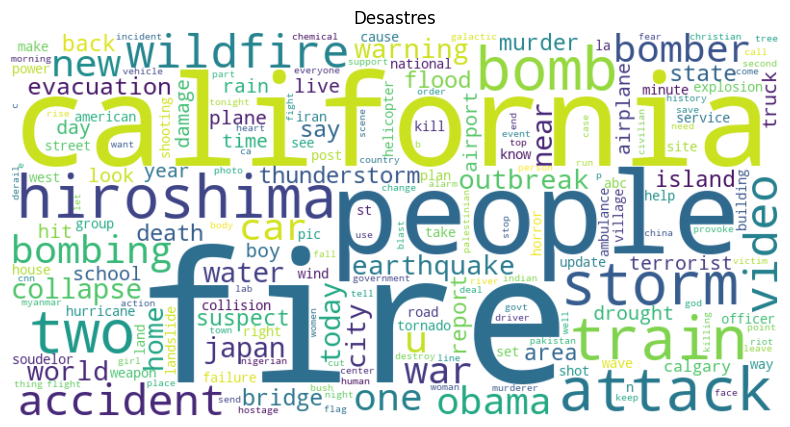

✅ Nube de palabras para Desastres generada.
🌐 Generando nube de palabras para No Desastres...


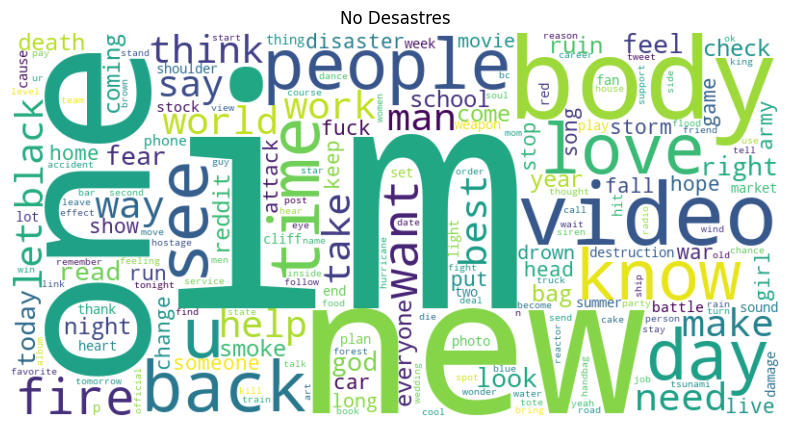

✅ Nube de palabras para No Desastres generada.


In [53]:
def plotWordCloud(wordFreqDf, title):
    print(f"🌐 Generando nube de palabras para {title}...")
    text = ' '.join(wordFreqDf['Word'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
    
    print(f"✅ Nube de palabras para {title} generada.")

plotWordCloud(disasterWordFreqDf, 'Desastres')
plotWordCloud(nonDisasterWordFreqDf, 'No Desastres')

#### 📊 Histogramas con las palabras más repetidas

📊 Generando histograma de palabras más frecuentes para Desastres...


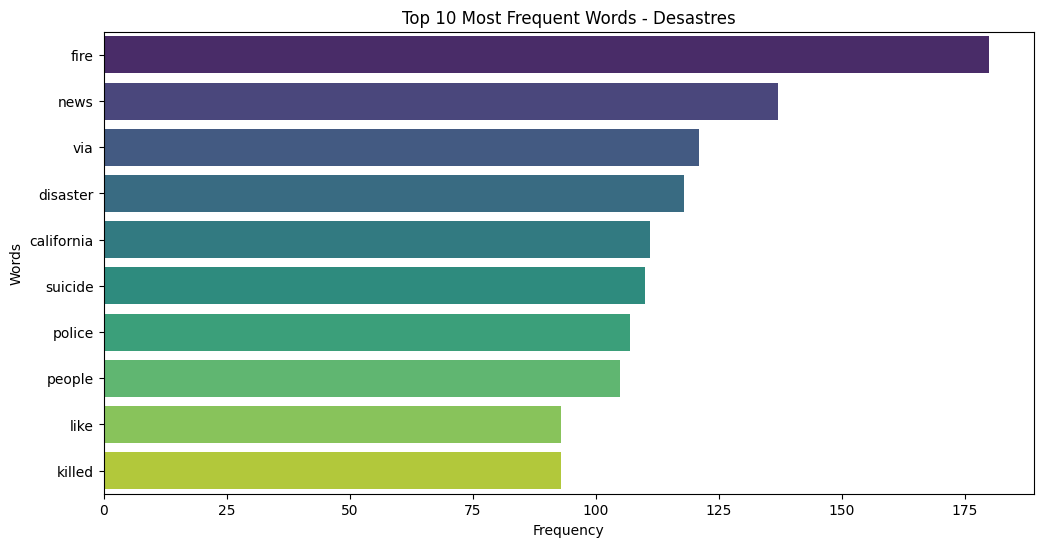

✅ Histograma de palabras más frecuentes para Desastres generado.
📊 Generando histograma de palabras más frecuentes para No Desastres...


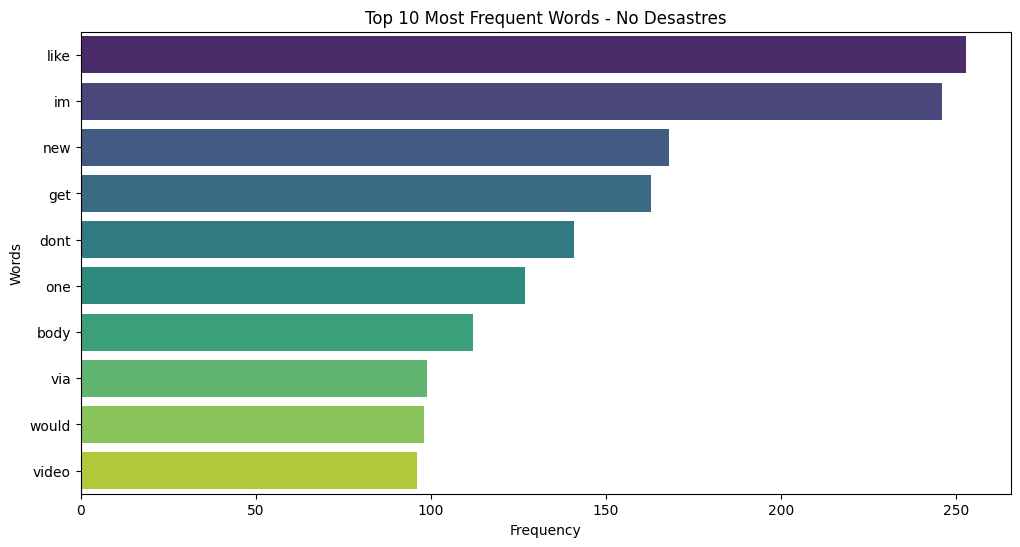

✅ Histograma de palabras más frecuentes para No Desastres generado.


In [54]:
def plotTopWordsHistogram(wordFreqDf, title):
    print(f"📊 Generando histograma de palabras más frecuentes para {title}...")
    topWords = wordFreqDf.head(10)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Frequency', y='Word', data=topWords, hue='Word', palette='viridis', legend=False)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top 10 Most Frequent Words - {title}')
    plt.show()
    
    print(f"✅ Histograma de palabras más frecuentes para {title} generado.")

plotTopWordsHistogram(disasterWordFreqDf, 'Desastres')
plotTopWordsHistogram(nonDisasterWordFreqDf, 'No Desastres')


🔍 Identificando palabras comunes en ambas categorías...
📚 Palabras comunes en ambas categorías:
{'michigan', 'policy', 'feet', 'transport', 'dangerous', 'cinema', 'fukushima', 'originalfunko', 'mercury', 'damages', 'improve', 'time2015', 'reason', 'hospital', 'high', 'loses', 'bruh', 'communities', 'ministers', 'floated', 'mud', 'cyber', 'like', 'waterresistant', 'fast', 'shes', 'philadelphia', 'accident', 'reasons', 'milk', 'precious', 'accounts', 'info', 'preparedness', 'beckarnley', 'enhanced', 'association', 'uniforms', 'bed', 'dare', 'glenn', 'director', 'bully', 'biological', 'official', 'belief', 'surfers', 'another', 'sometimes', 'rickperry', 'thee', 'ashes', 'enemy', 'food', 'wounds', 'messages', 'era', 'evacuation', 'ed', 'likely', 'hereûªs', 'famous', 'shooter', 'to', 'smoky', 'torch', 'usatoday', 'friends', 'personal', 'cannon', 'show', 'flattened', 'extremely', 'remains', 'attention', 'dan', 'memphis', 'fully', '53inch', 'animal', 'wheel', 'blazing', 'scares', 'wood', 'bli

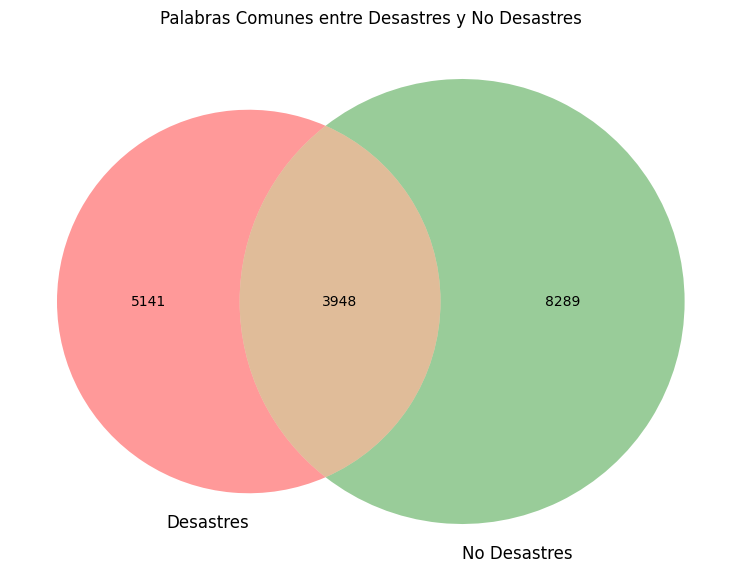

In [55]:
def commonWords(disasterWordFreqDf, nonDisasterWordFreqDf):
    print("🔍 Identificando palabras comunes en ambas categorías...")
    disasterWords = set(disasterWordFreqDf['Word'])
    nonDisasterWords = set(nonDisasterWordFreqDf['Word'])
    commonWords = disasterWords.intersection(nonDisasterWords)
    print("📚 Palabras comunes en ambas categorías:")
    print(commonWords)
    plt.figure(figsize=(10, 7))
    venn = venn2([disasterWords, nonDisasterWords], ('Desastres', 'No Desastres'))
    plt.title('Palabras Comunes entre Desastres y No Desastres')
    plt.show()

commonWords(disasterWordFreqDf, nonDisasterWordFreqDf)

### 😁 Inciso 6 - Clasificación de Tweets

In [56]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Descarga del léxico VADER
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def classify_words_by_sentiment(wordFreqDf):
    sentimentScores = {'Positive': [], 'Negative': [], 'Neutral': []}
    
    for word in wordFreqDf['Word']:
        sentiment = sia.polarity_scores(word) 
        
        if sentiment['compound'] >= 0.05:
            sentimentScores['Positive'].append((word, sentiment['compound']))
        elif sentiment['compound'] <= -0.05:
            sentimentScores['Negative'].append((word, sentiment['compound']))
        else:
            sentimentScores['Neutral'].append((word, sentiment['compound']))
    
    return sentimentScores, sentiment


disasterSentiment, sentiment = classify_words_by_sentiment(disasterWordFreqDf)
nonDisasterSentiment, sentiment = classify_words_by_sentiment(nonDisasterWordFreqDf)

print("\n🔍 Sentimientos en palabras de desastres reales:")
print("Positivas:", len(disasterSentiment['Positive']))
print("Negativas:", len(disasterSentiment['Negative']))
print("Neutrales:", len(disasterSentiment['Neutral']))

print("\n🔍 Sentimientos en palabras de no desastres:")
print("Positivas:", len(nonDisasterSentiment['Positive']))
print("Negativas:", len(nonDisasterSentiment['Negative']))
print("Neutrales:", len(nonDisasterSentiment['Neutral']))



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lijv1.LINDA_HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



🔍 Sentimientos en palabras de desastres reales:
Positivas: 337
Negativas: 523
Neutrales: 8229

🔍 Sentimientos en palabras de no desastres:
Positivas: 533
Negativas: 623
Neutrales: 11081


In [58]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Descargar léxico VADER si no está descargado
nltk.download('vader_lexicon')

# Inicializar el analizador de sentimientos
sia = SentimentIntensityAnalyzer()

def analyze_tweet_sentiment(tweet):
    positive_count = 0
    negative_count = 0
    neutral_count = 0
    
    # Tokenizar el tweet para obtener palabras individuales
    words = tweet.split()
    
    # Recorremos cada palabra del tweet
    for word in words:
        sentiment = sia.polarity_scores(word)  # Obtener el puntaje de sentimiento de cada palabra
        
        if sentiment['compound'] >= 0.05:  # Si es positivo
            positive_count += 1
        elif sentiment['compound'] <= -0.05:  # Si es negativo
            negative_count += 1
        else:  # Si es neutral
            neutral_count += 1
    
    total_words = len(words)
    
    if total_words == 0:
        return "Neutral"  # Si el tweet no tiene palabras, lo consideramos neutral
    
    # Proporción de palabras positivas, negativas y neutras
    positive_percentage = (positive_count / total_words) * 100
    negative_percentage = (negative_count / total_words) * 100
    neutral_percentage = (neutral_count / total_words) * 100
    
    # Determinar la clasificación general
    if positive_percentage > negative_percentage:
        sentiment = f"Positivo ({positive_percentage:.2f}%)"
    elif negative_percentage > positive_percentage:
        sentiment = f"Negativo ({negative_percentage:.2f}%)"
    else:
        sentiment = f"Neutral ({neutral_percentage:.2f}%)"
    
    return sentiment, positive_count, negative_count, neutral_count

# Aplicamos la función a cada tweet en la lista
tweet_list = [
    analyze_tweet_sentiment(tweet) for tweet in textWithoutStopwords
]

# Mostramos los resultados
for i, (sentiment, pos_count, neg_count, neu_count) in enumerate(tweet_list[:5]):
    print(f" \n🐦 Tweet {i+1}: {textWithoutStopwords[i]}")
    print(f"Sentimiento: {sentiment}")
    print(f"Palabras positivas: {pos_count}")
    print(f"Palabras negativas: {neg_count}")
    print(f"Palabras neutrales: {neu_count}")
    print()



🐦 Tweet 1: deeds reason earthquake may allah forgive us
Sentimiento: Positivo (28.57%)
Trigramas positivos: 2
Trigramas negativos: 0
Trigramas neutrales: 3


🐦 Tweet 2: forest fire near la ronge sask canada
Sentimiento: Negativo (28.57%)
Trigramas positivos: 0
Trigramas negativos: 2
Trigramas neutrales: 3


🐦 Tweet 3: residents asked shelter place notified officers evacuation shelter place orders expected
Sentimiento: Neutral (81.82%)
Trigramas positivos: 0
Trigramas negativos: 0
Trigramas neutrales: 9


🐦 Tweet 4: people receive wildfires evacuation orders california
Sentimiento: Neutral (66.67%)
Trigramas positivos: 0
Trigramas negativos: 0
Trigramas neutrales: 4


🐦 Tweet 5: got sent photo ruby alaska smoke wildfires pours school
Sentimiento: Neutral (77.78%)
Trigramas positivos: 0
Trigramas negativos: 0
Trigramas neutrales: 7



In [59]:
data = dataTrain.copy()
data['textWithoutStopwords'] = textWithoutStopwords



In [60]:
from tabulate import tabulate

data[['Sentiment', 'Positive_Count', 'Negative_Count', 'Neutral_Count']] = data['textWithoutStopwords'].apply(analyze_tweet_sentiment).apply(pd.Series)

# Agregar columna para la categoría
data['Category'] = data['target'].apply(lambda x: 'Desastre' if x == 1 else 'No Desastre')

# Top 10 tweets más negativos en general
top_10_negative = data.nlargest(10, 'Negative_Count')[['textWithoutStopwords', 'Negative_Count', 'Category']]
top_10_positive = data.nlargest(10, 'Positive_Count')[['textWithoutStopwords', 'Positive_Count', 'Category']]

# Mostrar resultados usando formato 'grid'
print("\n🔍 Los 10 tweets más negativos:")
print(tabulate(top_10_negative, headers='keys', tablefmt='fancy_grid', showindex=False))
print("\n🔍 Los 10 tweets más positivos:")
print(tabulate(top_10_positive, headers='keys', tablefmt='fancy_grid', showindex=False))

# Comparar el sentimiento promedio
disaster_tweets_df = data[data['target'] == 1]
non_disaster_tweets_df = data[data['target'] == 0]

avg_negative_disaster = disaster_tweets_df['Negative_Count'].mean()
avg_negative_non_disaster = non_disaster_tweets_df['Negative_Count'].mean()

# Convertir los promedios a porcentaje
avg_negative_disaster_percentage = avg_negative_disaster * 100 / disaster_tweets_df['textWithoutStopwords'].str.split().apply(len).mean()
avg_negative_non_disaster_percentage = avg_negative_non_disaster * 100 / non_disaster_tweets_df['textWithoutStopwords'].str.split().apply(len).mean()

# Mostrar los promedios en porcentaje
print(f"\n🔍 Promedio de palabras negativas en tweets de desastres: {avg_negative_disaster_percentage:.2f}%")
print(f"🔍 Promedio de palabras negativas en tweets de no desastres: {avg_negative_non_disaster_percentage:.2f}%")

if avg_negative_disaster_percentage > avg_negative_non_disaster_percentage:
    print("Los tweets de desastres reales son más negativos que los de la otra categoría.")
else:
    print("Los tweets de desastres reales no son más negativos que los de la otra categoría.")


🔍 Los 10 tweets más negativos:
╒════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════════╤═════════════╕
│ textWithoutStopwords                                                                                                                       │   Negative_Count │ Category    │
╞════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪══════════════════╪═════════════╡
│ metal cutting sparks brush fire brighton brush fire sparked landowner cutting metal burned û_                                              │               11 │ Desastre    │
├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────┼─────────────┤
│ bomb crash loot riot emergency pipe bomb nuclear chemical spill gas ricin leak violenc

### 🧠 Inciso 8. Modelo CNN con negatividad

#### 🗂️ Dividir en entrenamiento y prueba (80 - 20).

In [61]:
# Datos de ejemplo
sentences = textWithoutStopwords.tolist()
targets = dataTrain['target'].tolist()
testSentences = dataTest['text'].tolist()

# Dividir los datos en conjuntos de entrenamiento y prueba
trainingSize = int(len(sentences) * 0.80)
trainingSentences = sentences[:trainingSize]
testingSentences = sentences[trainingSize:]
trainingTargets = targets[:trainingSize]
testingTargets = targets[trainingSize:]

# Convertir a arrays
trainingTargetsArray = np.array(trainingTargets)
testingTargetsArray = np.array(testingTargets)

# Crear el array para las etiquetas
training_targets_array = np.array(trainingTargets)
testing_targets_array = np.array(testingTargets)

#### 🖼️ Tokenización y aplicación de padding.

In [62]:
# Tokenización y padding
tokenizer = Tokenizer(num_words=500, oov_token='<OOV>')
tokenizer.fit_on_texts(trainingSentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(trainingSentences)
training_padded = pad_sequences(training_sequences, maxlen=40, padding='post', truncating='post')
testing_sequences = tokenizer.texts_to_sequences(testingSentences)
testing_padded = pad_sequences(testing_sequences, maxlen=40, padding='post', truncating='post')
main_test_sequence = tokenizer.texts_to_sequences(testSentences)
main_test_padded = pad_sequences(main_test_sequence, maxlen=40, padding='post', truncating='post')

# Crear una variable de negatividad para el conjunto de entrenamiento y prueba
negativity_scores = [analyze_tweet_sentiment(tweet)[1] for tweet in sentences]
negativity_scores_train = negativity_scores[:trainingSize]
negativity_scores_test = negativity_scores[trainingSize:]

# Convertir la variable de negatividad a arrays
training_negativity_array = np.array(negativity_scores_train).reshape(-1, 1)
testing_negativity_array = np.array(negativity_scores_test).reshape(-1, 1)

In [63]:
# Función para agregar ruido a la capa de embedding
def add_embedding_noise(embedding, noise_factor=0.1):
    noise = tf.random.normal(shape=tf.shape(embedding), mean=0.0, stddev=noise_factor, dtype=tf.float32)
    return embedding + noise


In [64]:
# Crear una variable de negatividad para el conjunto de entrenamiento y prueba
negativity_scores = [analyze_tweet_sentiment(tweet)[1] for tweet in sentences]
negativity_scores_train = negativity_scores[:trainingSize]
negativity_scores_test = negativity_scores[trainingSize:]

# Convertir la variable de negatividad a arrays
training_negativity_array = np.array(negativity_scores_train).reshape(-1, 1)
testing_negativity_array = np.array(negativity_scores_test).reshape(-1, 1)


def create_combined_input(text_sequences, negativity_array):
    # Concatenar secuencias de texto y negatividad
    combined = np.hstack([text_sequences, np.repeat(negativity_array, text_sequences.shape[1], axis=1)])
    return combined

# Convertir las secuencias de texto y negatividad a arrays
training_padded_combined = create_combined_input(training_padded, training_negativity_array)
testing_padded_combined = create_combined_input(testing_padded, testing_negativity_array)



In [65]:
# Definir el modelo
input_text = layers.Input(shape=(40,))
input_negativity = layers.Input(shape=(1,))

embedding_layer = layers.Embedding(500, 16, input_length=40)(input_text)
conv1 = layers.Conv1D(128, 5, activation='relu')(embedding_layer)
pool1 = layers.MaxPooling1D(pool_size=4)(conv1)
conv2 = layers.Conv1D(64, 5, activation='relu')(pool1)
pool2 = layers.MaxPooling1D(pool_size=4)(conv2)
flatten_layer = layers.Flatten()(pool2)

# Concatenar la salida de la red convolucional con la variable de negatividad
concat_layer = layers.concatenate([flatten_layer, input_negativity])

dense_layer = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(concat_layer)
dense_layer = layers.Dropout(0.5)(dense_layer)
output_layer = layers.Dense(1, activation='sigmoid')(dense_layer)

# Crear el modelo
model = Model(inputs=[input_text, input_negativity], outputs=output_layer)

# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Mostrar resumen del modelo
model.summary()

c:\Users\lijv1.LINDA_HP\Documents\GitHub\Lab06_DSAnalisisSentimientos\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 16)    │      8,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 36, 128)   │     10,368 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 9, 128)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5, 64)     │     41,024 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1, 64)     │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 65)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,224 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 63,681 (248.75 KB)

 Trainable params: 63,681 (248.75 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Entrenar el modelo
history = model.fit(
    [training_padded, training_negativity_array],  # Entradas: texto y negatividad
    training_targets_array,                       # Salida: etiquetas
    epochs=15,                                     # Número de épocas
    validation_data=([testing_padded, testing_negativity_array], testing_targets_array)  # Datos de validación
)


Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5735 - loss: 0.7095 - val_accuracy: 0.7295 - val_loss: 0.5504
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7694 - loss: 0.5099 - val_accuracy: 0.7387 - val_loss: 0.5336
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8030 - loss: 0.4598 - val_accuracy: 0.7387 - val_loss: 0.5326
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8156 - loss: 0.4297 - val_accuracy: 0.7347 - val_loss: 0.5598
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8171 - loss: 0.4140 - val_accuracy: 0.7367 - val_loss: 0.5594
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8356 - loss: 0.3983 - val_accuracy: 0.7308 - val_loss: 0.5648
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8480 - loss: 0.3762 - val_accuracy: 0.7393 - val_loss: 0.5596
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8571 - loss: 0.3491 - val_accuracy: 0.

In [67]:
test_loss, test_accuracy = model.evaluate([testing_padded, testing_negativity_array], testing_targets_array)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7165 - loss: 0.8653
Test Loss: 0.8756
Test Accuracy: 0.7085


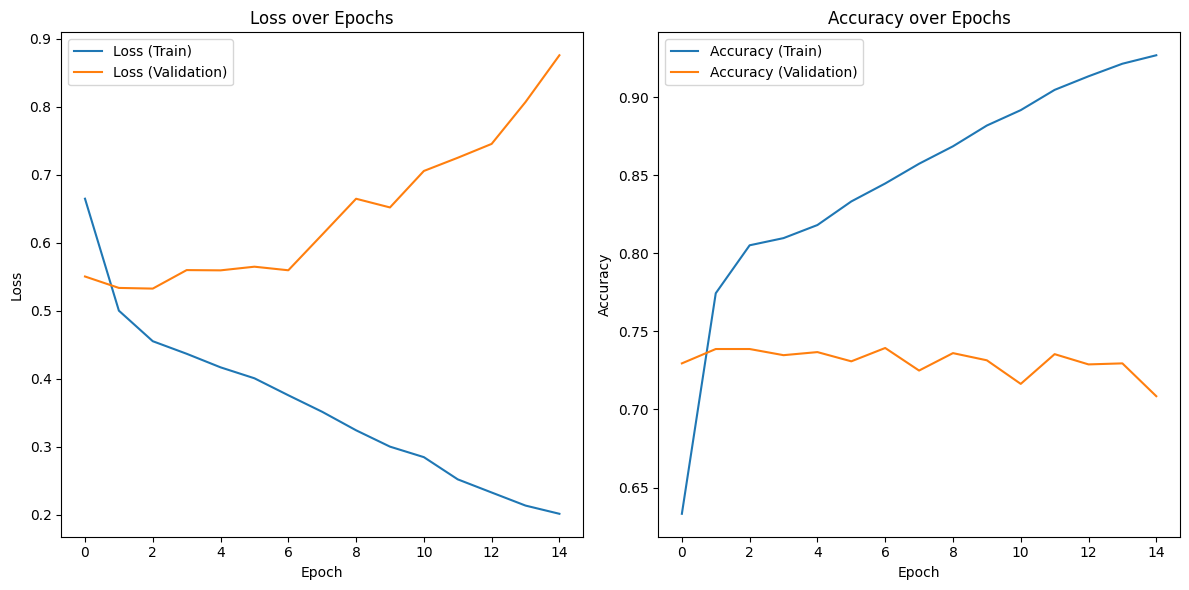

In [68]:
import matplotlib.pyplot as plt

# Graficar el historial de entrenamiento
plt.figure(figsize=(12, 6))

# Graficar la pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Graficar la precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy (Train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (Validation)')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [69]:
# Ejemplo de primeros 10 tweets de prueba
sample_tweets = dataTest['text'].head(10).tolist()

# Tokenizar y aplicar padding
sample_sequences = tokenizer.texts_to_sequences(sample_tweets)
sample_padded = pad_sequences(sample_sequences, maxlen=40, padding='post', truncating='post')

# Calcular la negatividad para los primeros 10 tweets
sample_negativity_scores = [analyze_tweet_sentiment(tweet)[1] for tweet in sample_tweets]
sample_negativity_array = np.array(sample_negativity_scores).reshape(-1, 1)

# Realizar predicciones
predictions = model.predict([sample_padded, sample_negativity_array])

# Convertir predicciones a etiquetas
predicted_classes = (predictions > 0.5).astype(int)  # Umbral para clasificación binaria

# Mostrar resultados
for i, tweet in enumerate(sample_tweets):
    sentiment = 'Desastre' if predicted_classes[i] == 1 else 'No Desastre'
    print(f"Tweet {i+1}: {tweet}")
    print(f"Predicción: {sentiment}")
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Tweet 1: Just happened a terrible car crash
Predicción: No Desastre

Tweet 2: Heard about #earthquake is different cities, stay safe everyone.
Predicción: Desastre

Tweet 3: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
Predicción: Desastre

Tweet 4: Apocalypse lighting. #Spokane #wildfires
Predicción: No Desastre

Tweet 5: Typhoon Soudelor kills 28 in China and Taiwan
Predicción: No Desastre

Tweet 6: We're shaking...It's an earthquake
Predicción: Desastre

Tweet 7: They'd probably still show more life than Arsenal did yesterday, eh? EH?
Predicción: No Desastre

Tweet 8: Hey! How are you?
Predicción: No Desastre

Tweet 9: What a nice hat?
Predicción: No Desastre

Tweet 10: Fuck off!
Predicción: No Desastre



# 🥫 Ejercicio 2

### 📩 Inciso 1. Descargar el archivo train.csv

In [70]:
'''if not os.path.isdir('grammar-and-online-product-reviews'):
    od.download("https://www.kaggle.com/datasets/datafiniti/grammar-and-online-product-reviews")'''

'if not os.path.isdir(\'grammar-and-online-product-reviews\'):\n    od.download("https://www.kaggle.com/datasets/datafiniti/grammar-and-online-product-reviews")'

### 📩 Inciso 2. Carga de los datos

In [91]:
data = pd.read_csv('GrammarandProductReviews.csv')
data.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


### 🧹 Inciso 3. Preprocesamiento y limpieza de datos

In [92]:
data.describe()

,reviews.id,reviews.numHelpful,reviews.rating
count,3.215800e+04,32508.000000,71044.000000
mean,7.944753e+07,0.410422,4.385747
std,4.842696e+07,3.574442,1.067659
min,2.187400e+04,0.000000,1.000000
25%,3.355342e+07,0.000000,4.000000
50%,7.124763e+07,0.000000,5.000000
75%,1.112628e+08,0.000000,5.000000
max,1.038227e+09,183.000000,5.000000


In [93]:
num_filas = data.shape[0]
print(f"Número de filas: {num_filas}")

Número de filas: 71044


In [94]:
for i, element in enumerate(data.columns):
    print(str(i+1)+")📚["+element+"].Count:", data[element].count())

1)📚[id].Count: 71044
2)📚[brand].Count: 71044
3)📚[categories].Count: 71044
4)📚[dateAdded].Count: 71044
5)📚[dateUpdated].Count: 71044
6)📚[ean].Count: 39065
7)📚[keys].Count: 71044
8)📚[manufacturer].Count: 70903
9)📚[manufacturerNumber].Count: 70841
10)📚[name].Count: 71044
11)📚[reviews.date].Count: 70977
12)📚[reviews.dateAdded].Count: 71044
13)📚[reviews.dateSeen].Count: 71044
14)📚[reviews.didPurchase].Count: 32158
15)📚[reviews.doRecommend].Count: 60429
16)📚[reviews.id].Count: 32158
17)📚[reviews.numHelpful].Count: 32508
18)📚[reviews.rating].Count: 71044
19)📚[reviews.sourceURLs].Count: 71044
20)📚[reviews.text].Count: 71008
21)📚[reviews.title].Count: 70567
22)📚[reviews.userCity].Count: 5410
23)📚[reviews.userProvince].Count: 449
24)📚[reviews.username].Count: 70942
25)📚[upc].Count: 71042


In [95]:
data.drop(columns=['dateAdded', 'dateUpdated', 'ean', 'keys', 'manufacturerNumber', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.sourceURLs', 'reviews.userCity', 'reviews.dateSeen', 'reviews.numHelpful', 'reviews.userProvince', 'upc'], inplace=True)

In [96]:
data.head()

,id,brand,categories,manufacturer,name,reviews.date,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.username
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Joshua
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,100209113.0,5,Good flavor. This review was collected as part...,Good,Dorothy W
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,100209113.0,5,Good flavor.,Good,Dorothy W
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,113026909.0,1,I read through the reviews on here before look...,Disappointed,Rebecca
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,171267657.0,1,My husband bought this gel for us. The gel cau...,Irritation,Walker557


In [97]:
# Eliminar filas que tengan NaN en la columna 'text'
data = data.dropna(subset=['reviews.text'])
data = data.dropna(subset=['reviews.doRecommend'])
data = data.reset_index(drop=True)
text = data['reviews.text']
num_filas = data.shape[0]
print(f"Número de filas: {num_filas}")

Número de filas: 60427


#### 🖼️ Removiendo urls

In [98]:
textWithoutUrl = text.str.replace(r'http\S+|www\S+', '', regex=True)
printText(textWithoutUrl, 100)

0 I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.
1 My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.
2 My boyfriend and I bought this to spice things up in the bedroom and we were both highly disappointed in this product. We bought this one because we absolutely love

#### 🔡 Convertir a minúsculas. 

In [99]:
textLowerCase = textWithoutUrl.str.lower()
textLowerCase.head()

0    i read through the reviews on here before look...
1    my husband bought this gel for us. the gel cau...
2    my boyfriend and i bought this to spice things...
3    bought this earlier today and was excited to c...
4    i bought this product for my husband and i to ...
Name: reviews.text, dtype: object

#### 🤔 Removiendo caracteres especiales (@/#/')

In [100]:
textWithouthSpecialCharacthers = textLowerCase.str.replace('@', '')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('#', '')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace("'", "")
textWithouthSpecialCharacthers.head()

0    i read through the reviews on here before look...
1    my husband bought this gel for us. the gel cau...
2    my boyfriend and i bought this to spice things...
3    bought this earlier today and was excited to c...
4    i bought this product for my husband and i to ...
Name: reviews.text, dtype: object

#### 👾 Removiendo patrones extraños

In [101]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'\?+', '?', regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'\!+', '!', regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('&amp;', 'and')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('\n', ' ')
printText(textWithouthSpecialCharacthers, stop=20)

0 i read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didnt even live up to the reviews i had read. for starters, neither my boyfriend nor i could notice any sort of enhanced or captivating sensation. what we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. it was difficult to clean up, and was not a pleasant, especially since it lacked the captivating sensation we had both been expecting. im disappointed that i paid as much as i did for a lube that i wont use again, when i could just use their normal personal lubricant for 1) less money and 2) less mess.
1 my husband bought this gel for us. the gel caused irritation and it felt like it was burning my skin. i wouldnt recommend this gel.
2 my boyfriend and i bought this to spice things up in the bedroom and we were both highly disappointed in this product. we bought this one because we absolutely love the ky 

#### 📚 Reduciendo la cantidad de letras repetidas

In [102]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'(\.{3,})', 'THREEPOINTSIDENFIFIER', regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'(.)\1{'+str(2)+',}', r'\1' * 2, regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('THREEPOINTSIDENFIFIER', '...')
textWithouthSpecialCharacthers

0        i read through the reviews on here before look...
1        my husband bought this gel for us. the gel cau...
2        my boyfriend and i bought this to spice things...
3        bought this earlier today and was excited to c...
4        i bought this product for my husband and i to ...
                               ...                        
60422    im dealing with dry eyes and very sensitive to...
60423    great stuff! helps keep my contacts moist all ...
60424                                          right price
60425    i was so pleased when this scarf arrived for m...
60426    excellent album, makes the holidays better, gi...
Name: reviews.text, Length: 60427, dtype: object

#### 🛹 Quintando puntos y comas.

In [103]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('.',' ')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(',',' ')
printText(textWithouthSpecialCharacthers, 100)

0 i read through the reviews on here before looking in to buying one of the couples lubricants  and was ultimately disappointed that it didnt even live up to the reviews i had read  for starters  neither my boyfriend nor i could notice any sort of enhanced or captivating sensation  what we did notice  however  was the messy consistency that was reminiscent of a more liquid-y vaseline  it was difficult to clean up  and was not a pleasant  especially since it lacked the captivating sensation we had both been expecting  im disappointed that i paid as much as i did for a lube that i wont use again  when i could just use their normal personal lubricant for 1) less money and 2) less mess 
1 my husband bought this gel for us  the gel caused irritation and it felt like it was burning my skin  i wouldnt recommend this gel 
2 my boyfriend and i bought this to spice things up in the bedroom and we were both highly disappointed in this product  we bought this one because we absolutely love the ky 

#### 🧹 Removiendo varios espacios en blanco y dejando solo uno

In [104]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'\s{2,}', ' ', regex=True)
printText(textWithouthSpecialCharacthers, 100)

0 i read through the reviews on here before looking in to buying one of the couples lubricants and was ultimately disappointed that it didnt even live up to the reviews i had read for starters neither my boyfriend nor i could notice any sort of enhanced or captivating sensation what we did notice however was the messy consistency that was reminiscent of a more liquid-y vaseline it was difficult to clean up and was not a pleasant especially since it lacked the captivating sensation we had both been expecting im disappointed that i paid as much as i did for a lube that i wont use again when i could just use their normal personal lubricant for 1) less money and 2) less mess 
1 my husband bought this gel for us the gel caused irritation and it felt like it was burning my skin i wouldnt recommend this gel 
2 my boyfriend and i bought this to spice things up in the bedroom and we were both highly disappointed in this product we bought this one because we absolutely love the ky yours and mine

#### 🧹 Removiendo stopwords y números  

In [105]:
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))

def removeStopwordsAndNumbers(text):
    if isinstance(text, str):  # Verifica si el valor es una cadena de texto
        # Elimina números y caracteres especiales
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        # Divide el texto en palabras y filtra las stopwords
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stopWords]
        return ' '.join(filtered_words)
    else:
        return text  # Retorna el valor original si no es una cadena de texto

# Aplicar la función a cada elemento de la Serie
textWithoutStopwords = textWithouthSpecialCharacthers.apply(removeStopwordsAndNumbers)
printText(textWithoutStopwords, 100)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lijv1.LINDA_HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0 read reviews looking buying one couples lubricants ultimately disappointed didnt even live reviews read starters neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lacked captivating sensation expecting im disappointed paid much lube wont use could use normal personal lubricant less money less mess
1 husband bought gel us gel caused irritation felt like burning skin wouldnt recommend gel
2 boyfriend bought spice things bedroom highly disappointed product bought one absolutely love ky mine thought would similar affect absolutely nothing buy
3 bought earlier today excited check based product description expecting something like regular ky fans expected left little disappointed
4 bought product husband try impressed tingling warming left us sticky used ky products past loved ky one disappointing
5 husband bought extra fun werevboth extremely disappointed especially pri

In [106]:
textWithoutStopwords = textWithoutStopwords.str.replace(r'[^\w\s]','',regex=True)

### 📚 Inciso 4. Análisis exploratorio

In [107]:
nltk.download('punkt_tab')
tokenizedText = textWithoutStopwords.apply(word_tokenize)
allWords = [word for words in tokenizedText for word in words]
wordCounts = Counter(allWords)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lijv1.LINDA_HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


           Word  Frequency
2853      movie      19883
215       great      18152
64         love      14221
62      product      13290
239      review      13193
407        part      13043
39          use      12403
408   promotion      12362
406   collected      12355
209        good      10388


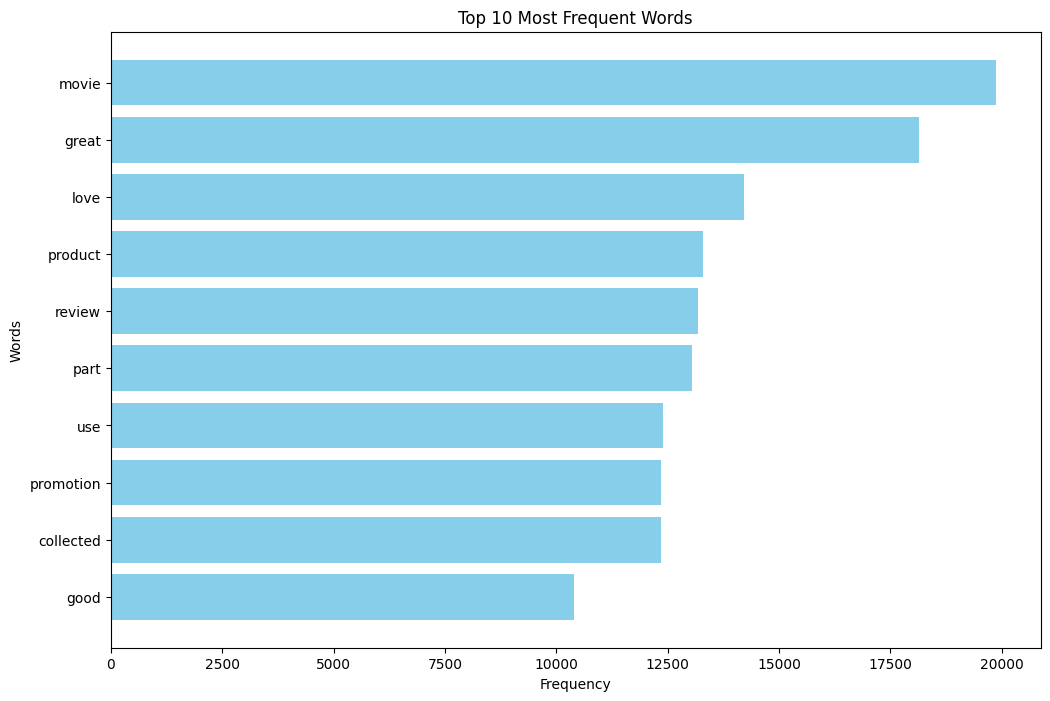

In [108]:
wordFreqDf = pd.DataFrame(wordCounts.items(), columns=['Word', 'Frequency'])
wordFreqDf = wordFreqDf.sort_values(by='Frequency', ascending=False)
print(wordFreqDf.head(10))
plt.figure(figsize=(12, 8))
plt.barh(wordFreqDf['Word'].head(10), wordFreqDf['Frequency'].head(10), color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 10 Most Frequent Words')
plt.gca().invert_yaxis() 
plt.show()

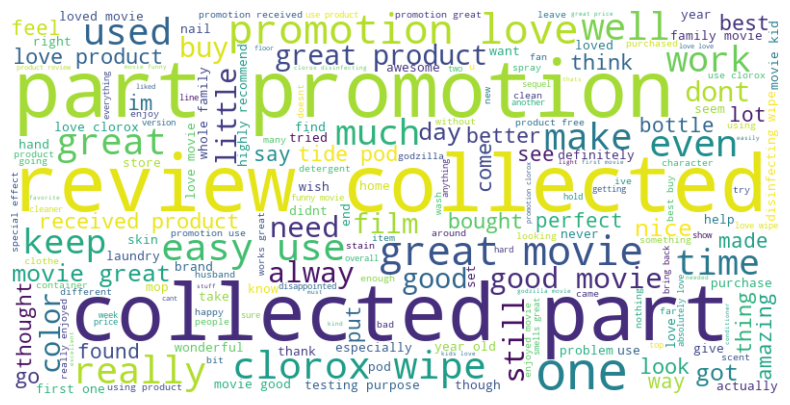

In [109]:
completeText = ' '.join(allWords)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(completeText)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [110]:
def mostFrequentWords(tokenizedTextColumn, targetColumn):
    print("🔄 Analizando palabras más frecuentes por categoría...")
    
    goodReview = tokenizedTextColumn[targetColumn == True]
    badReview = tokenizedTextColumn[targetColumn == False]
    
    def countWords(texts):
        wordsList = [word for tokens in texts for word in tokens]
        wordCounts = Counter(wordsList)
        return wordCounts
    
    goodReviewrWordCounts = countWords(goodReview)
    badReviewWordCounts = countWords(badReview)
    goodReviewWordFreqDf = pd.DataFrame(goodReviewrWordCounts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
    badReviewWordFreqDf = pd.DataFrame(badReviewWordCounts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
    
    print("📈 Palabra más frecuente en Good Review:")
    print(goodReviewWordFreqDf.head(1))
    
    print("📈 Palabra más frecuente en Bad Review:")
    print(badReviewWordFreqDf.head(1))
    
    return goodReviewWordFreqDf, badReviewWordFreqDf

goodReviewWordFreqDf, badReviewWordFreqDf = mostFrequentWords(tokenizedText, data['reviews.doRecommend'])

🔄 Analizando palabras más frecuentes por categoría...
📈 Palabra más frecuente en Good Review:
       Word  Frequency
2511  movie      18733
📈 Palabra más frecuente en Bad Review:
       Word  Frequency
62  product       1738


🌐 Generando nube de palabras para Good Reviews...


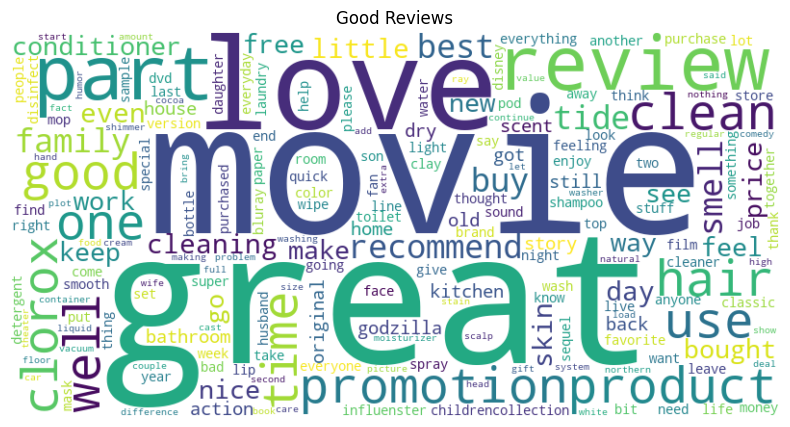

✅ Nube de palabras para Good Reviews generada.
🌐 Generando nube de palabras para Bad Reviews...


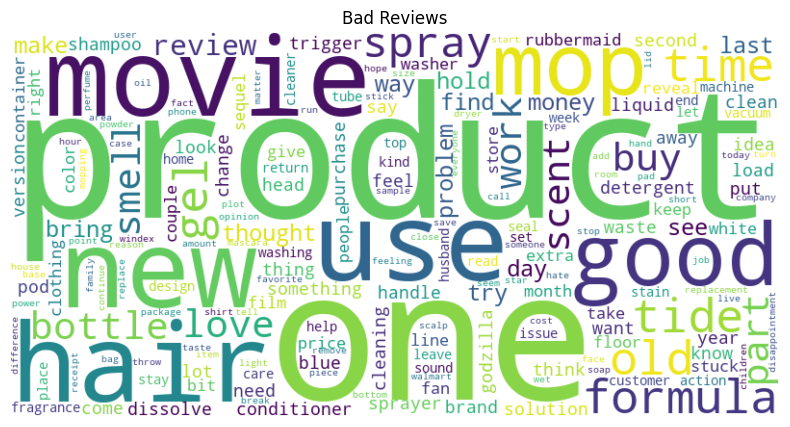

✅ Nube de palabras para Bad Reviews generada.


In [111]:
def plotWordCloud(wordFreqDf, title):
    print(f"🌐 Generando nube de palabras para {title}...")
    text = ' '.join(wordFreqDf['Word'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
    
    print(f"✅ Nube de palabras para {title} generada.")

plotWordCloud(goodReviewWordFreqDf, 'Good Reviews')
plotWordCloud(badReviewWordFreqDf, 'Bad Reviews')

📊 Generando histograma de palabras más frecuentes para Good Reviews...


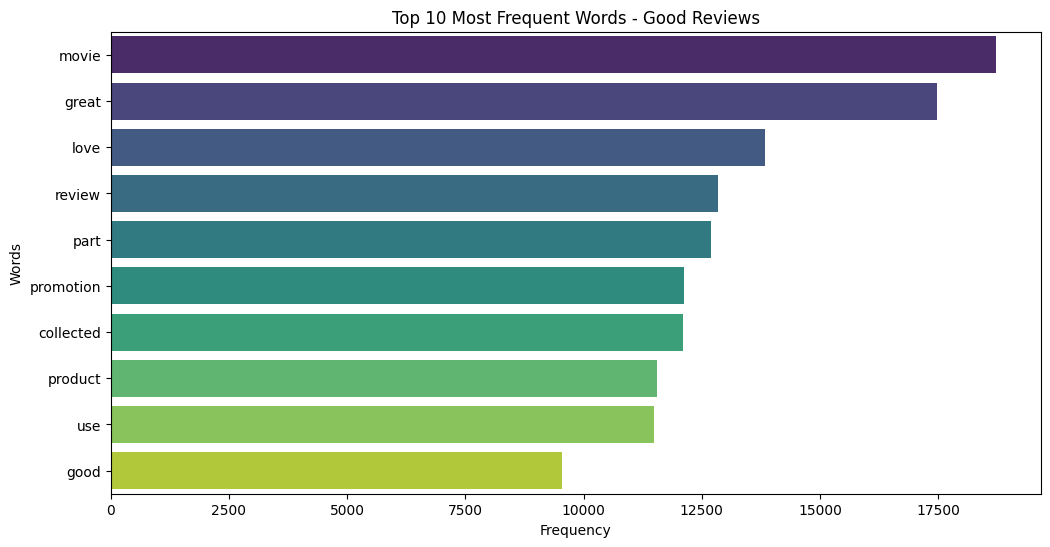

✅ Histograma de palabras más frecuentes para Good Reviews generado.
📊 Generando histograma de palabras más frecuentes para Bad Reviews...


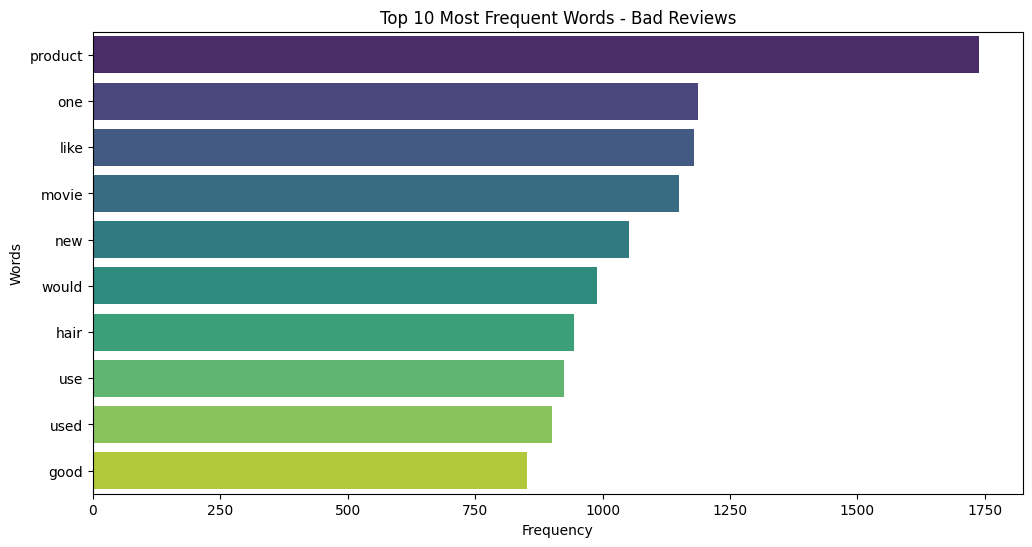

✅ Histograma de palabras más frecuentes para Bad Reviews generado.


In [112]:
def plotTopWordsHistogram(wordFreqDf, title):
    print(f"📊 Generando histograma de palabras más frecuentes para {title}...")
    topWords = wordFreqDf.head(10)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Frequency', y='Word', data=topWords, hue='Word', palette='viridis', legend=False)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top 10 Most Frequent Words - {title}')
    plt.show()
    
    print(f"✅ Histograma de palabras más frecuentes para {title} generado.")

plotTopWordsHistogram(goodReviewWordFreqDf, 'Good Reviews')
plotTopWordsHistogram(badReviewWordFreqDf, 'Bad Reviews')

🔍 Identificando palabras comunes en ambas categorías...
📚 Palabras comunes en ambas categorías:
{'thermostat', 'hesitate', 'concluded', 'manage', 'shimmers', 'compilation', 'dial', 'alike', 'share', 'frequencies', 'binge', 'comparing', 'ken', 'went', 'donate', 'dad', 'dated', 'compliment', 'navy', 'bits', 'manually', 'goodie', 'millions', 'stuck', 'weighed', 'jam', 'listening', 'powers', 'meer', 'sentimental', 'ill', 'steelbook', 'morals', 'xbox', 'preassembled', 'corrected', 'score', 'essentials', 'half', 'informed', 'insisted', 'armpits', 'sugar', 'event', 'hard', 'included', 'sparkling', 'mats', 'forgo', 'dancing', 'comedic', 'farm', 'hurt', 'pushes', 'breaks', 'restrictions', 'confused', 'mankind', 'newer', 'defeated', 'weirdest', 'owns', 'lightness', 'spare', 'libman', 'depressing', 'lenses', 'invisible', 'visits', 'wave', 'functioned', 'triggers', 'pumpkin', 'spoken', 'balloons', 'thr', 'group', 'vacuuming', 'track', 'purchasing', 'empty', 'iam', 'interpretation', 'include', 'lon

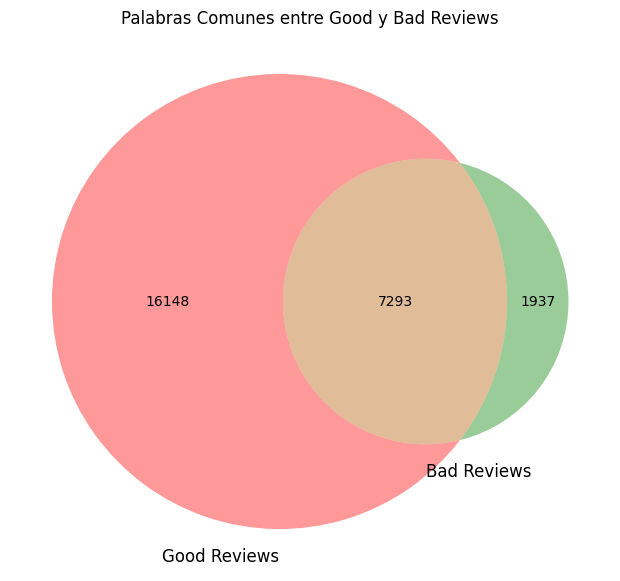

In [113]:
def commonWords(disasterWordFreqDf, nonDisasterWordFreqDf):
    print("🔍 Identificando palabras comunes en ambas categorías...")
    disasterWords = set(disasterWordFreqDf['Word'])
    nonDisasterWords = set(nonDisasterWordFreqDf['Word'])
    commonWords = disasterWords.intersection(nonDisasterWords)
    print("📚 Palabras comunes en ambas categorías:")
    print(commonWords)
    plt.figure(figsize=(10, 7))
    venn = venn2([disasterWords, nonDisasterWords], ('Good Reviews', 'Bad Reviews'))
    plt.title('Palabras Comunes entre Good y Bad Reviews')
    plt.show()

commonWords(goodReviewWordFreqDf, badReviewWordFreqDf)

🔄 Generando 2-gramas...
📈 Mostrando los 10 2-gramas más frecuentes:
Label                Bad Reviews  Good Reviews
2-gram                                        
(clorox, wipes)               15          1950
(collected, part)            244         12110
(easy, use)                   38          1936
(good, movie)                 45          1285
(great, movie)                20          2168
(great, product)              49          1203
(love, product)               14          1034
(part, promotion)            244         12110
(review, collected)          244         12110
(would, recommend)            87           993


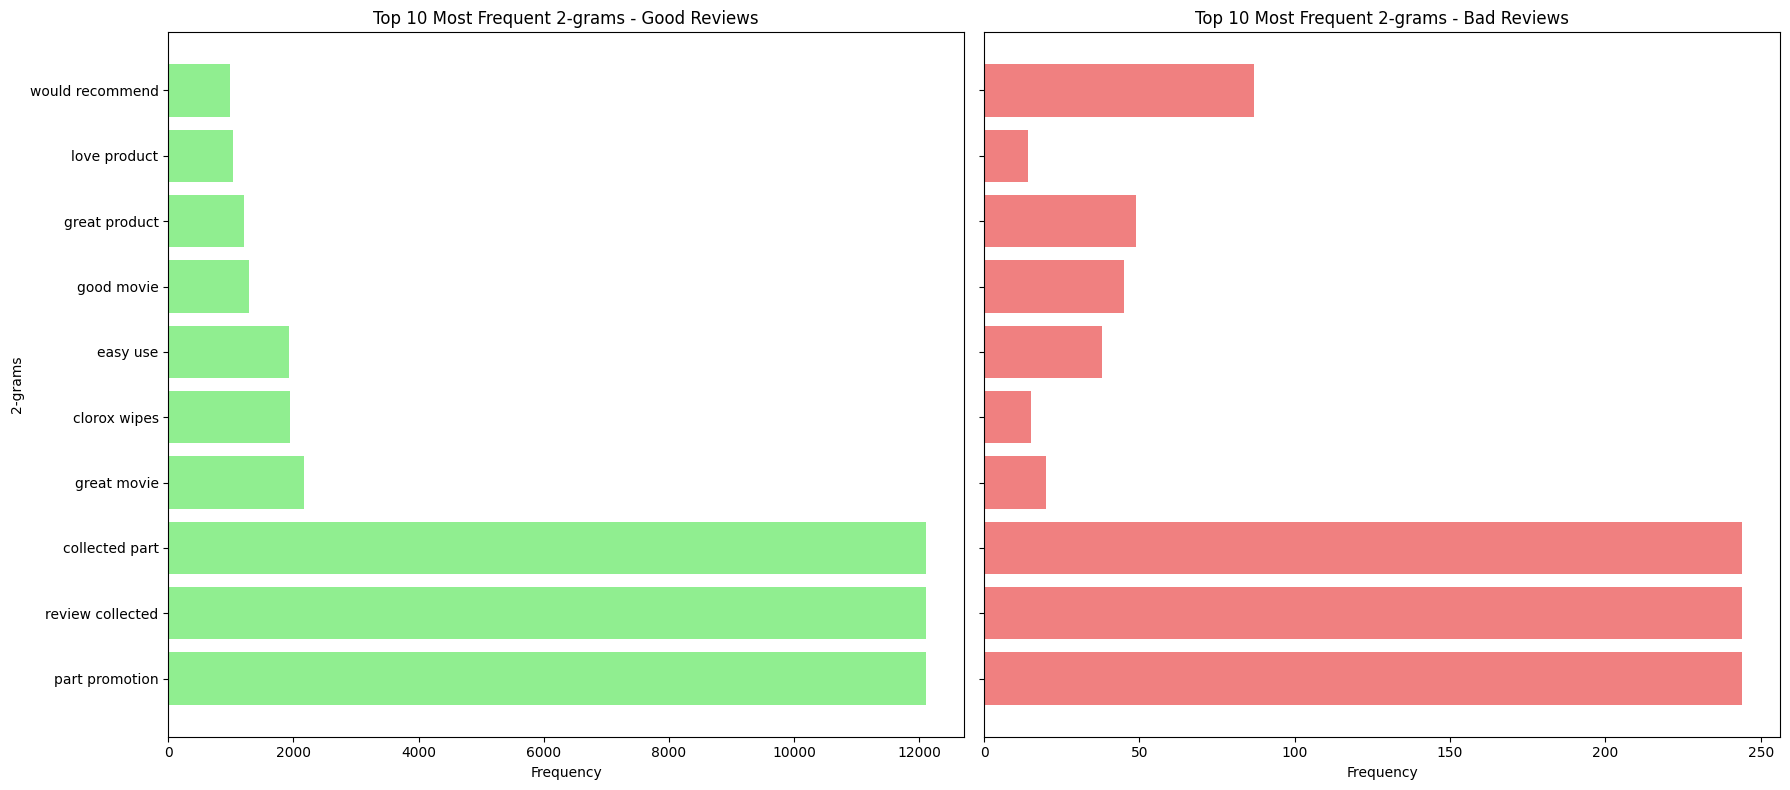

✅ Gráficos de 2-gramas generados.
🔄 Generando 3-gramas...
📈 Mostrando los 10 3-gramas más frecuentes:
Label                          Bad Reviews  Good Reviews
3-gram                                                  
(clean, review, collected)             1.0         367.0
(clorox, disinfecting, wipes)          NaN         472.0
(collected, part, promotion)         244.0       12110.0
(love, clorox, wipes)                  8.0         462.0
(opinions, review, collected)         22.0         419.0
(please, bring, back)                128.0         207.0
(product, review, collected)           4.0         475.0
(received, product, free)             28.0         420.0
(review, collected, part)            244.0       12110.0
(testing, purposes, opinions)         23.0         349.0


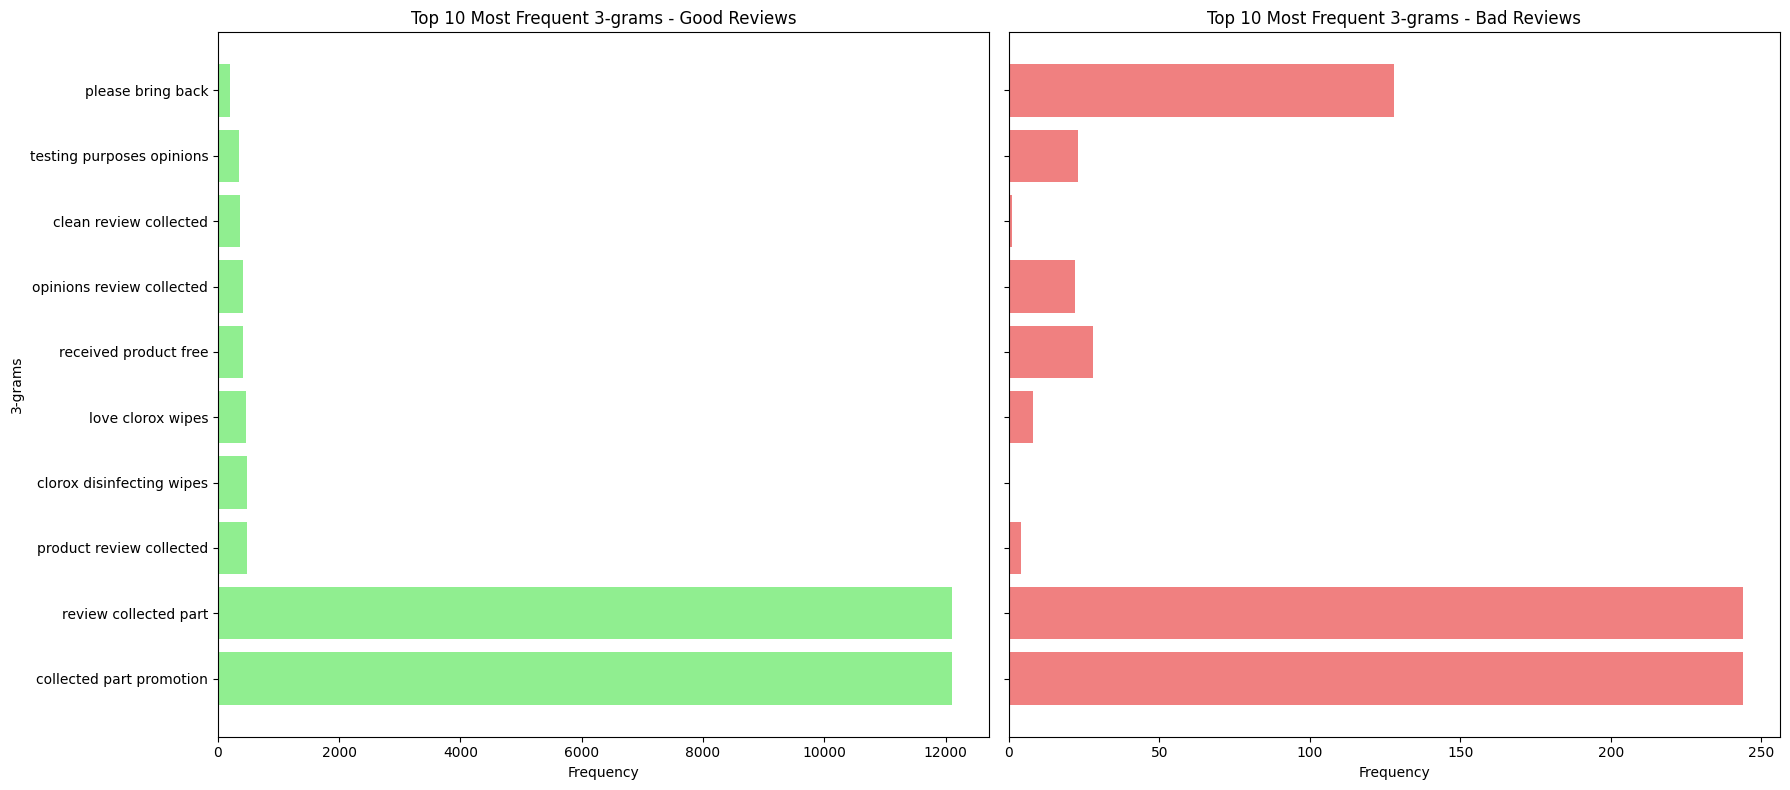

✅ Gráficos de 3-gramas generados.


(                                 3-gram  Frequency         Label
 527        (collected, part, promotion)      12110  Good Reviews
 526           (review, collected, part)      12110  Good Reviews
 842        (product, review, collected)        475  Good Reviews
 66302     (clorox, disinfecting, wipes)        472  Good Reviews
 66294             (love, clorox, wipes)        462  Good Reviews
 ...                                 ...        ...           ...
 204112  (buying, watching, nonetheless)          1  Good Reviews
 204111        (godzilla, worth, buying)          1  Good Reviews
 204110        (showed, godzilla, worth)          1  Good Reviews
 204109       (longer, showed, godzilla)          1  Good Reviews
 565160          (nice, christmas, vibe)          1  Good Reviews
 
 [565161 rows x 3 columns],
                                    3-gram  Frequency        Label
 250          (collected, part, promotion)        244  Bad Reviews
 249             (review, collected, part)  

In [114]:
def ngramAnalysis(tokenizedTextColumn, targetColumn, n=2):
    print(f"🔄 Generando {n}-gramas...")

    goodReviews = tokenizedTextColumn[targetColumn == True]
    badRaeviews = tokenizedTextColumn[targetColumn == False]
    
    def analyzeNgrams(texts, label):
        ngramsList = [ngram for tokens in texts for ngram in ngrams(tokens, n)]
        ngramCounts = Counter(ngramsList)
        ngramFreqDf = pd.DataFrame(ngramCounts.items(), columns=[f'{n}-gram', 'Frequency']).sort_values(by='Frequency', ascending=False)
        ngramFreqDf['Label'] = label
        return ngramFreqDf
    
    goodReviewsNgramsDf = analyzeNgrams(goodReviews, 'Good Reviews')
    badRaeviewsNgramsDf = analyzeNgrams(badRaeviews, 'Bad Reviews')
    
    topNgrams = pd.concat([goodReviewsNgramsDf, badRaeviewsNgramsDf]).groupby([f'{n}-gram'])['Frequency'].sum().sort_values(ascending=False).head(10).index
    topNgramsDf = pd.concat([goodReviewsNgramsDf, badRaeviewsNgramsDf])
    topNgramsDf = topNgramsDf[topNgramsDf[f'{n}-gram'].isin(topNgrams)]

    print(f"📈 Mostrando los 10 {n}-gramas más frecuentes:")
    print(topNgramsDf.groupby([f'{n}-gram', 'Label'])['Frequency'].sum().unstack())


    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
    

    disasterSubset = topNgramsDf[topNgramsDf['Label'] == 'Good Reviews']
    axs[0].barh([' '.join(ngram) for ngram in disasterSubset[f'{n}-gram']], disasterSubset['Frequency'], color='lightgreen')
    axs[0].set_xlabel('Frequency')
    axs[0].set_ylabel(f'{n}-grams')
    axs[0].set_title(f'Top 10 Most Frequent {n}-grams - Good Reviews')
    axs[0].invert_yaxis()
    
    nonDisasterSubset = topNgramsDf[topNgramsDf['Label'] == 'Bad Reviews']
    axs[1].barh([' '.join(ngram) for ngram in nonDisasterSubset[f'{n}-gram']], nonDisasterSubset['Frequency'], color='lightcoral')
    axs[1].set_xlabel('Frequency')
    axs[1].set_title(f'Top 10 Most Frequent {n}-grams - Bad Reviews')
    axs[1].invert_yaxis()

    plt.tight_layout()
    plt.show()
    print(f"✅ Gráficos de {n}-gramas generados.")

    return goodReviewsNgramsDf, badRaeviewsNgramsDf

ngramAnalysis(tokenizedText, data['reviews.doRecommend'], n=2)
ngramAnalysis(tokenizedText, data['reviews.doRecommend'], n=3)

In [115]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Descarga del léxico VADER
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def classify_words_by_sentiment(wordFreqDf):
    sentimentScores = {'Positive': [], 'Negative': [], 'Neutral': []}
    
    for word in wordFreqDf['Word']:
        sentiment = sia.polarity_scores(word) 
        
        if sentiment['compound'] >= 0.05:
            sentimentScores['Positive'].append((word, sentiment['compound']))
        elif sentiment['compound'] <= -0.05:
            sentimentScores['Negative'].append((word, sentiment['compound']))
        else:
            sentimentScores['Neutral'].append((word, sentiment['compound']))
    
    return sentimentScores, sentiment


goodReviewSentiment, sentiment = classify_words_by_sentiment(goodReviewWordFreqDf)
badReviewSentiment, sentiment = classify_words_by_sentiment(badReviewWordFreqDf)

print("\n🔍 Sentimientos en palabras de Good Reviews:")
print("Positivas:", len(goodReviewSentiment['Positive']))
print("Negativas:", len(goodReviewSentiment['Negative']))
print("Neutrales:", len(goodReviewSentiment['Neutral']))

print("\n🔍 Sentimientos en palabras de Bad Reviews:")
print("Positivas:", len(badReviewSentiment['Positive']))
print("Negativas:", len(badReviewSentiment['Negative']))
print("Neutrales:", len(badReviewSentiment['Neutral']))



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lijv1.LINDA_HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



🔍 Sentimientos en palabras de Good Reviews:
Positivas: 1084
Negativas: 1042
Neutrales: 21315

🔍 Sentimientos en palabras de Bad Reviews:
Positivas: 564
Negativas: 572
Neutrales: 8094


### 😁 Inciso 5 - Clasificación de Reviews

In [116]:
# Inicializar el analizador de sentimientos
sia = SentimentIntensityAnalyzer()

def analyze_tweet_sentiment(tweet):
    positive_count = 0
    negative_count = 0
    neutral_count = 0
    
    # Tokenizar el tweet para obtener palabras individuales
    words = word_tokenize(tweet)
    
    # Generar trigramas a partir de las palabras
    tweet_trigrams = list(trigrams(words))
    
    # Recorremos cada trigrama del tweet
    for trigrama in tweet_trigrams:
        # Unimos las tres palabras del trigrama en una sola cadena
        trigrama_str = ' '.join(trigrama)
        
        # Obtener el puntaje de sentimiento del trigrama
        sentiment = sia.polarity_scores(trigrama_str)
        
        if sentiment['compound'] >= 0.05:  # Si es positivo
            positive_count += 1
        elif sentiment['compound'] <= -0.05:  # Si es negativo
            negative_count += 1
        else:  # Si es neutral
            neutral_count += 1
    
    # Si no hay trigramas, analizar las palabras individuales
    if not tweet_trigrams:
        words = [word.lower() for word in words]  # Convertir a minúsculas
        for word in words:
            sentiment = sia.polarity_scores(word)  # Obtener el puntaje de sentimiento de cada palabra
            
            if sentiment['compound'] >= 0.05:  # Si es positivo
                positive_count += 1
            elif sentiment['compound'] <= -0.05:  # Si es negativo
                negative_count += 1
            else:  # Si es neutral
                neutral_count += 1
    
    total_trigrams = len(tweet_trigrams)
    total_words = len(words)
    
    if total_trigrams == 0 and total_words == 0:
        return "Neutral", 0, 0, 0  # Si el tweet está vacío, lo consideramos neutral
    
    # Proporción de trigramas positivos, negativos y neutros
    positive_percentage = (positive_count / max(total_trigrams, total_words)) * 100
    negative_percentage = (negative_count / max(total_trigrams, total_words)) * 100
    neutral_percentage = (neutral_count / max(total_trigrams, total_words)) * 100
    
    # Determinar la clasificación general
    if positive_percentage > negative_percentage:
        sentiment = f"Positivo ({positive_percentage:.2f}%)"
    elif negative_percentage > positive_percentage:
        sentiment = f"Negativo ({negative_percentage:.2f}%)"
    else:
        sentiment = f"Neutral ({neutral_percentage:.2f}%)"
    
    return sentiment, positive_count, negative_count, neutral_count

# Aplicamos la función a cada tweet en la lista
tweet_list = [
    analyze_tweet_sentiment(tweet) for tweet in textWithoutStopwords
]

# Mostramos los resultados
for i, (sentiment, pos_count, neg_count, neu_count) in enumerate(tweet_list[:5]):
    print(f"\n🥫 Review {i+1}: {textWithoutStopwords[i]}")
    print(f"Sentimiento: {sentiment}")
    print(f"Trigramas positivos: {pos_count if len(textWithoutStopwords[i].split()) >= 3 else 0}")
    print(f"Trigramas negativos: {neg_count if len(textWithoutStopwords[i].split()) >= 3 else 0}")
    print(f"Trigramas neutrales: {neu_count if len(textWithoutStopwords[i].split()) >= 3 else 0}")
    print()



🥫 Review 1: read reviews looking buying one couples lubricants ultimately disappointed didnt even live reviews read starters neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lacked captivating sensation expecting im disappointed paid much lube wont use could use normal personal lubricant less money less mess
Sentimiento: Negativo (20.00%)
Trigramas positivos: 4
Trigramas negativos: 11
Trigramas neutrales: 38


🥫 Review 2: husband bought gel us gel caused irritation felt like burning skin wouldnt recommend gel
Sentimiento: Negativo (35.71%)
Trigramas positivos: 2
Trigramas negativos: 5
Trigramas neutrales: 5


🥫 Review 3: boyfriend bought spice things bedroom highly disappointed product bought one absolutely love ky mine thought would similar affect absolutely nothing buy
Sentimiento: Neutral (61.90%)
Trigramas positivos: 3
Trigramas negativos: 3
Trigramas neutrales

### 📈 Inciso 6 - Estadísticas

In [118]:
data = data.copy()
data['textWithoutStopwords'] = textWithoutStopwords

In [138]:
# Clasificar la reseña como positiva o negativa basado en VADER
def classify_review_sentiment(review):
    sentiment = sia.polarity_scores(review)
    if sentiment['compound'] >= 0.05:
        return 'Positive'
    elif sentiment['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Añadir una columna de sentimiento
data['sentiment'] = data['textWithoutStopwords'].apply(classify_review_sentiment)

data['reviews.username'] = data['reviews.username'].str.lower()

# Reemplazamos cualquier valor que contenga 'anonymous' por 'anonymous'
data['reviews.username'] = data['reviews.username'].fillna('anonymous')
data.loc[data['reviews.username'].str.contains('anonymous'), 'reviews.username'] = 'Anonymous'

# Filtrar reseñas positivas
positive_reviews = data[data['sentiment'] == 'Positive']

# Agrupar por producto y contar cuántas reseñas positivas tiene cada producto
top_10_quality_products = positive_reviews.groupby('name')['textWithoutStopwords'].count().nlargest(10)

# Convertir los resultados en un dataframe para utilizar tabulate
top_10_quality_df = top_10_quality_products.reset_index().rename(columns={'name': 'Product', 'textWithoutStopwords': 'Positive Reviews Count'})

# Filtrar reseñas negativas
negative_reviews = data[data['sentiment'] == 'Negative']

# Agrupar por producto y contar cuántas reseñas negativas tiene cada producto
bottom_10_quality_products = negative_reviews.groupby('name')['textWithoutStopwords'].count().nlargest(10)

bottom_10_quality_products_df = bottom_10_quality_products.reset_index().rename(columns={'name': 'Product', 'textWithoutStopwords': 'Negative Reviews Count'})


# Mostrar los resultados con tabulate
print(tabulate(top_10_quality_df, headers='keys', tablefmt='fancy_grid'))
print(tabulate(bottom_10_quality_products_df, headers='keys', tablefmt='fancy_grid'))

# Contar cuántos productos únicos ha reseñado cada usuario
user_review_count = data.groupby('reviews.username')['name'].nunique().nlargest(10)
user_review_count_df = user_review_count.reset_index().rename(columns={'reviews.username': 'Username', 'name': 'Unique Products Reviewed'})

print(tabulate(user_review_count_df, headers='keys', tablefmt='fancy_grid'))

total_reseñas_por_usuario = data.groupby('reviews.username').size().reset_index(name='total_reseñas')

# Contar el número de reseñas positivas por usuario
conteo_positivas = positive_reviews.groupby('reviews.username').size().reset_index(name='positive_reviews')

# Unir los conteos con el total de reseñas
positive_reviews_df = pd.merge(total_reseñas_por_usuario, conteo_positivas, on='reviews.username', how='left')

# Rellenar valores NaN con 0 para reseñas positivas
positive_reviews_df['positive_reviews'] = positive_reviews_df['positive_reviews'].fillna(0).astype(int)

# Ordenar por el número de reseñas positivas
positive_reviews_df = positive_reviews_df.sort_values(by='positive_reviews', ascending=False).head(10)

print(tabulate(positive_reviews_df, headers='keys', tablefmt='fancy_grid'))

# Contar el número de reseñas positivas por usuario
conteo_negativas = negative_reviews.groupby('reviews.username').size().reset_index(name='negative_reviews')

# Unir los conteos con el total de reseñas
negative_reviews_df = pd.merge(total_reseñas_por_usuario, conteo_negativas, on='reviews.username', how='left')

# Rellenar valores NaN con 0 para reseñas positivas
negative_reviews_df['negative_reviews'] = negative_reviews_df['negative_reviews'].fillna(0).astype(int)

# Ordenar por el número de reseñas positivas
negative_reviews_df = negative_reviews_df.sort_values(by='negative_reviews', ascending=False).head(10)

print(tabulate(negative_reviews_df, headers='keys', tablefmt='fancy_grid'))


# Agrupar por productor y contar cuántas reseñas positivas tienen sus productos
top_producers_quality = positive_reviews.groupby('manufacturer')['textWithoutStopwords'].nunique().nlargest(10)
top_producers_quality_df = top_producers_quality.reset_index().rename(columns={'manufacturer': 'Manufacturer', 'textWithoutStopwords': 'Positive Reviews Count'})
print(tabulate(top_producers_quality_df, headers='keys', tablefmt='fancy_grid'))

top_bottom_producers_quality = negative_reviews.groupby('manufacturer')['textWithoutStopwords'].nunique().nlargest(10)
top_bottom_producers_quality_df = top_bottom_producers_quality.reset_index().rename(columns={'manufacturer': 'Manufacturer', 'textWithoutStopwords': 'Negative Reviews Count'})
print(tabulate(top_bottom_producers_quality_df, headers='keys', tablefmt='fancy_grid'))


╒════╤════════════════════════════════════════════════════════════════════════════════╤══════════════════════════╕
│    │ Product                                                                        │   Positive Reviews Count │
╞════╪════════════════════════════════════════════════════════════════════════════════╪══════════════════════════╡
│  0 │ Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                      │                     7816 │
├────┼────────────────────────────────────────────────────────────────────────────────┼──────────────────────────┤
│  1 │ The Secret Life Of Pets (4k/uhd + Blu-Ray + Digital)                           │                     5271 │
├────┼────────────────────────────────────────────────────────────────────────────────┼──────────────────────────┤
│  2 │ Independence Day Resurgence (4k/uhd + Blu-Ray + Digital)                       │                     3191 │
├────┼──────────────────────────────────────────────────────────────────────────